In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn.functional as F

# Adam, additivity

torch.set_default_dtype(torch.float64)


def f_(X):
    return torch.sin(np.pi*X)
    #return X**2

def f(X,Y):
    return f_(X) + f_(Y)


n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
#n_grids = [10,20]
#n_grids = [5]

errors = []
errors_test = []

ii = 0

for n_grid in n_grids:
    print("n_grid={}".format(n_grid))
    #n_grid = 400


    x = torch.linspace(-1,1,steps=n_grid)
    y = torch.linspace(-1,1,steps=n_grid)
    x_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    y_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    X, Y = torch.meshgrid(x, y)

    # full have shape (2, n_grid)
    def add(full):
        return full[0,:].unsqueeze(dim=0) + full[1,:].unsqueeze(dim=1)
        

    def add_loss(full, x, y):
        f_numerical = add(full)
        X, Y = torch.meshgrid(x[:],y[:])
        f_true = f(X,Y)
        return torch.mean((f_numerical-f_true)**2)

    # initalize z as random parameters, note sequential training
    #z = g(X,Y)
    if ii == 0:
    #if True:
        #z = torch.stack([f_(x), f_(y)])
        z = torch.normal(0,1,size=(2,n_grid))*0.001
        z = torch.nn.Parameter(z, requires_grad=True)
    else:
        z = F.interpolate(z.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,n_grid), mode='bilinear', align_corners=True)[0,0]
        z = torch.nn.Parameter(z, requires_grad=True)
        
    ii = ii + 1
    
    # initialize adam (learning rate scaling lr~h**4), z as parameters
    lr = 1e-2
    opt = torch.optim.Adam({z}, lr=lr, eps=1e-8)
    #opt = torch.optim.SGD({z}, lr=lr)
    
    # iterations here (learning rate decay)
    epochs = 50000
    switch_epoch = 5000
    log = 100
    best_loss = 1e20
    losses = []
    
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            loss_train = add_loss(z, x, y)
            z_interp = F.interpolate(z.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,2*n_grid-1), mode='bilinear', align_corners=True)[0,0]
            z_test = z_interp[:,1:-1:2]
            loss_test = add_loss(z_test, x_test, y_test)
            loss = (loss_test*(n_grid-1)**2 + loss_train*(n_grid)**2)/((n_grid-1)**2+(n_grid)**2)
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        opt.step(loss_closure)  # get loss, use to update wts
        if loss < best_loss:
            best_loss = loss
            best_epoch = i
            best_z = z.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    
    errors.append(best_loss.detach().numpy())
    
    torch.save(z, './add_results_grid/z_n_{}'.format(n_grid))
    torch.save(best_loss, './add_results_grid/loss_n_{}'.format(n_grid))


n_grid=10
Epoch: 0 | Loss: 0.00027283268535570516
Epoch: 100 | Loss: 0.00014531942451208925
Epoch: 200 | Loss: 0.00014531539380087814
Epoch: 300 | Loss: 0.0001453153937281476
Epoch: 400 | Loss: 0.00014531539372814715
Epoch: 500 | Loss: 0.0001453153937281472
Epoch: 600 | Loss: 0.00014531539372814706
Epoch: 700 | Loss: 0.00014531539372814682
Epoch: 800 | Loss: 0.0001453153937281469
Epoch: 900 | Loss: 0.00014531539372814706
Epoch: 1000 | Loss: 0.00014531539372814666
Epoch: 1100 | Loss: 0.00014531539372814717
Epoch: 1200 | Loss: 0.00014531539372814696
Epoch: 1300 | Loss: 0.0001453153937281472
Epoch: 1400 | Loss: 0.00014531682590933405
Epoch: 1500 | Loss: 0.0001453153939892988
Epoch: 1600 | Loss: 0.00014531539372816316
Epoch: 1700 | Loss: 0.00014531539372814725
Epoch: 1800 | Loss: 0.00014531539372814725
Epoch: 1900 | Loss: 0.00014531539372814687
Epoch: 2000 | Loss: 0.000148663068845408
Epoch: 2100 | Loss: 0.00014531539615336012
Epoch: 2200 | Loss: 0.00014531539372855505
Epoch: 2300 | Loss: 

Epoch: 19000 | Loss: 0.00014531834042104253
Epoch: 19100 | Loss: 0.0001453153989089579
Epoch: 19200 | Loss: 0.00014531539372879227
Epoch: 19300 | Loss: 0.00014531539372814712
Epoch: 19400 | Loss: 0.00014531539372814687
Epoch: 19500 | Loss: 0.00014544081779791382
Epoch: 19600 | Loss: 0.00014531539697175004
Epoch: 19700 | Loss: 0.00014531539372849986
Epoch: 19800 | Loss: 0.00014531539372814698
Epoch: 19900 | Loss: 0.00014531539372814706
Epoch: 20000 | Loss: 0.0001453342012002371
Epoch: 20100 | Loss: 0.0001453153939803124
Epoch: 20200 | Loss: 0.00014531539372816146
Epoch: 20300 | Loss: 0.00014531539372814687
Epoch: 20400 | Loss: 0.00014531539372814717
Epoch: 20500 | Loss: 0.00014531539372814677
Epoch: 20600 | Loss: 0.00014531539372814698
Epoch: 20700 | Loss: 0.00014531539372814687
Epoch: 20800 | Loss: 0.0001453153937281469
Epoch: 20900 | Loss: 0.00014531539372814685
Epoch: 21000 | Loss: 0.00014531539372814715
Epoch: 21100 | Loss: 0.00014531539372814685
Epoch: 21200 | Loss: 0.0001453153937

Epoch: 38200 | Loss: 0.00014531539372814696
Epoch: 38300 | Loss: 0.00014531539372814698
Epoch: 38400 | Loss: 0.0001453153937281473
Epoch: 38500 | Loss: 0.00014531545861475801
Epoch: 38600 | Loss: 0.00014531539372880374
Epoch: 38700 | Loss: 0.00014531539372814685
Epoch: 38800 | Loss: 0.00014531539372814698
Epoch: 38900 | Loss: 0.00014531539372814734
Epoch: 39000 | Loss: 0.00014531539374694824
Epoch: 39100 | Loss: 0.00014531539391629672
Epoch: 39200 | Loss: 0.00014531539372814736
Epoch: 39300 | Loss: 0.00014531539372814723
Epoch: 39400 | Loss: 0.00014531539372814698
Epoch: 39500 | Loss: 0.00014531539372814742
Epoch: 39600 | Loss: 0.00014531539816459957
Epoch: 39700 | Loss: 0.000145315393728334
Epoch: 39800 | Loss: 0.00014531539372814687
Epoch: 39900 | Loss: 0.00014531539372814717
Epoch: 40000 | Loss: 0.00014531539372814717
Epoch: 40100 | Loss: 0.00014531539372814717
Epoch: 40200 | Loss: 0.00014531539372814744
Epoch: 40300 | Loss: 0.00014531539372814704
Epoch: 40400 | Loss: 0.000145315393

Epoch: 7400 | Loss: 2.5253878267366697e-05
Epoch: 7500 | Loss: 2.5253878267366663e-05
Epoch: 7600 | Loss: 2.5253878267415202e-05
Epoch: 7700 | Loss: 2.5254225116960682e-05
Epoch: 7800 | Loss: 2.5253878526993687e-05
Epoch: 7900 | Loss: 2.525387826736948e-05
Epoch: 8000 | Loss: 2.525387826736664e-05
Epoch: 8100 | Loss: 2.5253878267366738e-05
Epoch: 8200 | Loss: 2.5584063280665102e-05
Epoch: 8300 | Loss: 2.525388682650272e-05
Epoch: 8400 | Loss: 2.525387826763082e-05
Epoch: 8500 | Loss: 2.5253878267366606e-05
Epoch: 8600 | Loss: 2.525387826736663e-05
Epoch: 8700 | Loss: 2.651180575388786e-05
Epoch: 8800 | Loss: 2.525393794611977e-05
Epoch: 8900 | Loss: 2.5253878268594678e-05
Epoch: 9000 | Loss: 2.5253878267366657e-05
Epoch: 9100 | Loss: 2.5253878267366728e-05
Epoch: 9200 | Loss: 2.5691869436269228e-05
Epoch: 9300 | Loss: 2.5254076604095235e-05
Epoch: 9400 | Loss: 2.5253878269062857e-05
Epoch: 9500 | Loss: 2.525387826736678e-05
Epoch: 9600 | Loss: 2.5253878267366657e-05
Epoch: 9700 | Loss:

Epoch: 26400 | Loss: 2.5253878267366697e-05
Epoch: 26500 | Loss: 2.5253978907314767e-05
Epoch: 26600 | Loss: 2.525387826787074e-05
Epoch: 26700 | Loss: 2.525387826736676e-05
Epoch: 26800 | Loss: 2.5253878267366643e-05
Epoch: 26900 | Loss: 2.5253878267366585e-05
Epoch: 27000 | Loss: 2.5253878267366684e-05
Epoch: 27100 | Loss: 2.5254016134293675e-05
Epoch: 27200 | Loss: 2.5253878268076037e-05
Epoch: 27300 | Loss: 2.5253878267366738e-05
Epoch: 27400 | Loss: 2.525387826736663e-05
Epoch: 27500 | Loss: 2.5253878267366663e-05
Epoch: 27600 | Loss: 2.5255467389934174e-05
Epoch: 27700 | Loss: 2.525387913115071e-05
Epoch: 27800 | Loss: 2.5253878267369587e-05
Epoch: 27900 | Loss: 2.5253878267366677e-05
Epoch: 28000 | Loss: 2.5253878267366707e-05
Epoch: 28100 | Loss: 2.5253878267727913e-05
Epoch: 28200 | Loss: 2.5253883104165644e-05
Epoch: 28300 | Loss: 2.5253878267383912e-05
Epoch: 28400 | Loss: 2.5253878267366718e-05
Epoch: 28500 | Loss: 2.525387826736659e-05
Epoch: 28600 | Loss: 2.52538782673670

Epoch: 45300 | Loss: 2.5253878267366738e-05
Epoch: 45400 | Loss: 2.5253878267366657e-05
Epoch: 45500 | Loss: 2.5253878267366738e-05
Epoch: 45600 | Loss: 2.5253878267366694e-05
Epoch: 45700 | Loss: 2.5253878267366663e-05
Epoch: 45800 | Loss: 2.5253878267366606e-05
Epoch: 45900 | Loss: 2.5253878267366714e-05
Epoch: 46000 | Loss: 2.5253878267366704e-05
Epoch: 46100 | Loss: 2.5253878267366667e-05
Epoch: 46200 | Loss: 2.525387826736667e-05
Epoch: 46300 | Loss: 2.5253878267366704e-05
Epoch: 46400 | Loss: 2.5253878267366738e-05
Epoch: 46500 | Loss: 2.525387826736667e-05
Epoch: 46600 | Loss: 2.5253878267366633e-05
Epoch: 46700 | Loss: 2.5253878267366613e-05
Epoch: 46800 | Loss: 2.5253878279545208e-05
Epoch: 46900 | Loss: 2.525387826737297e-05
Epoch: 47000 | Loss: 2.525387826736659e-05
Epoch: 47100 | Loss: 2.5253878267366623e-05
Epoch: 47200 | Loss: 2.5253878267366718e-05
Epoch: 47300 | Loss: 2.525388125304793e-05
Epoch: 47400 | Loss: 2.525387826764683e-05
Epoch: 47500 | Loss: 2.525387826736662

Epoch: 14500 | Loss: 7.504936122366453e-06
Epoch: 14600 | Loss: 7.504936122366316e-06
Epoch: 14700 | Loss: 7.5051618590380915e-06
Epoch: 14800 | Loss: 7.504940753022783e-06
Epoch: 14900 | Loss: 7.504936126841017e-06
Epoch: 15000 | Loss: 7.504936122366361e-06
Epoch: 15100 | Loss: 7.504936122366329e-06
Epoch: 15200 | Loss: 7.50493612236634e-06
Epoch: 15300 | Loss: 7.504936122366344e-06
Epoch: 15400 | Loss: 7.5049361223663505e-06
Epoch: 15500 | Loss: 7.5049361223663505e-06
Epoch: 15600 | Loss: 7.504936122366302e-06
Epoch: 15700 | Loss: 7.5049361223663505e-06
Epoch: 15800 | Loss: 7.504936122366339e-06
Epoch: 15900 | Loss: 7.504936122366339e-06
Epoch: 16000 | Loss: 7.504936122366268e-06
Epoch: 16100 | Loss: 7.504936122366286e-06
Epoch: 16200 | Loss: 7.504936122366336e-06
Epoch: 16300 | Loss: 7.504936122366298e-06
Epoch: 16400 | Loss: 7.504936122366329e-06
Epoch: 16500 | Loss: 7.504936122366381e-06
Epoch: 16600 | Loss: 7.504936122427272e-06
Epoch: 16700 | Loss: 7.5052195199342374e-06
Epoch: 

Epoch: 33700 | Loss: 7.5049361847789416e-06
Epoch: 33800 | Loss: 7.504936122366303e-06
Epoch: 33900 | Loss: 7.504936122366345e-06
Epoch: 34000 | Loss: 7.504936122366321e-06
Epoch: 34100 | Loss: 7.504936122479078e-06
Epoch: 34200 | Loss: 7.5049383946317266e-06
Epoch: 34300 | Loss: 7.504936122438813e-06
Epoch: 34400 | Loss: 7.504936122366322e-06
Epoch: 34500 | Loss: 7.504936122366352e-06
Epoch: 34600 | Loss: 7.504936122366421e-06
Epoch: 34700 | Loss: 7.504939783640661e-06
Epoch: 34800 | Loss: 7.504936122535239e-06
Epoch: 34900 | Loss: 7.5049361223663505e-06
Epoch: 35000 | Loss: 7.504936122366371e-06
Epoch: 35100 | Loss: 7.504936122366375e-06
Epoch: 35200 | Loss: 7.5049361223663285e-06
Epoch: 35300 | Loss: 7.504936122366305e-06
Epoch: 35400 | Loss: 7.5049361223663344e-06
Epoch: 35500 | Loss: 7.504936122366305e-06
Epoch: 35600 | Loss: 7.504936122366302e-06
Epoch: 35700 | Loss: 7.5049361223663615e-06
Epoch: 35800 | Loss: 7.504936122366318e-06
Epoch: 35900 | Loss: 7.504936122366308e-06
Epoch

Epoch: 2800 | Loss: 2.9617736967663963e-06
Epoch: 2900 | Loss: 2.961773696766401e-06
Epoch: 3000 | Loss: 3.04733609730492e-06
Epoch: 3100 | Loss: 2.961788141460916e-06
Epoch: 3200 | Loss: 2.961773697514495e-06
Epoch: 3300 | Loss: 2.961773696766397e-06
Epoch: 3400 | Loss: 2.961773696766357e-06
Epoch: 3500 | Loss: 3.7347198461872673e-06
Epoch: 3600 | Loss: 2.961861391851031e-06
Epoch: 3700 | Loss: 2.9617736968905e-06
Epoch: 3800 | Loss: 2.9617736967663844e-06
Epoch: 3900 | Loss: 2.961773696766383e-06
Epoch: 4000 | Loss: 4.453296191737017e-06
Epoch: 4100 | Loss: 2.962302029805371e-06
Epoch: 4200 | Loss: 2.9617737277408665e-06
Epoch: 4300 | Loss: 2.961773696766583e-06
Epoch: 4400 | Loss: 2.9617736967663645e-06
Epoch: 4500 | Loss: 2.9619676182608377e-06
Epoch: 4600 | Loss: 2.961844295961539e-06
Epoch: 4700 | Loss: 2.9617737878490888e-06
Epoch: 4800 | Loss: 2.961773696768643e-06
Epoch: 4900 | Loss: 2.9617736967663675e-06
Epoch: 5000 | Loss: 2.9617737242089572e-06
Epoch: 5100 | Loss: 2.961773

Epoch: 22000 | Loss: 2.9617736967663772e-06
Epoch: 22100 | Loss: 2.9617736967663976e-06
Epoch: 22200 | Loss: 2.9618884563705634e-06
Epoch: 22300 | Loss: 2.9617736972220234e-06
Epoch: 22400 | Loss: 2.961773696766646e-06
Epoch: 22500 | Loss: 2.961773696766384e-06
Epoch: 22600 | Loss: 2.961773696766379e-06
Epoch: 22700 | Loss: 2.962435237627029e-06
Epoch: 22800 | Loss: 2.9617740537103417e-06
Epoch: 22900 | Loss: 2.961773696766768e-06
Epoch: 23000 | Loss: 2.961773696766407e-06
Epoch: 23100 | Loss: 2.9617736967664035e-06
Epoch: 23200 | Loss: 2.9633210673245237e-06
Epoch: 23300 | Loss: 2.9617780732279265e-06
Epoch: 23400 | Loss: 2.961773696820628e-06
Epoch: 23500 | Loss: 2.961773696766371e-06
Epoch: 23600 | Loss: 2.9617736967663938e-06
Epoch: 23700 | Loss: 2.9617749252962033e-06
Epoch: 23800 | Loss: 2.9617867212708195e-06
Epoch: 23900 | Loss: 2.961773697148996e-06
Epoch: 24000 | Loss: 2.961773696766409e-06
Epoch: 24100 | Loss: 2.9617736967663717e-06
Epoch: 24200 | Loss: 2.962377847658298e-06

Epoch: 41200 | Loss: 2.9617736967663938e-06
Epoch: 41300 | Loss: 2.961773696766382e-06
Epoch: 41400 | Loss: 2.961773696766384e-06
Epoch: 41500 | Loss: 2.9617736967663857e-06
Epoch: 41600 | Loss: 2.9617750687514948e-06
Epoch: 41700 | Loss: 2.9617736967734834e-06
Epoch: 41800 | Loss: 2.9617736967663925e-06
Epoch: 41900 | Loss: 2.961773696766384e-06
Epoch: 42000 | Loss: 2.961773696766384e-06
Epoch: 42100 | Loss: 2.9617738392571167e-06
Epoch: 42200 | Loss: 2.9617736978279365e-06
Epoch: 42300 | Loss: 2.96177369676645e-06
Epoch: 42400 | Loss: 2.961773696766368e-06
Epoch: 42500 | Loss: 2.9617736967663912e-06
Epoch: 42600 | Loss: 2.961773696766467e-06
Epoch: 42700 | Loss: 2.961773811076461e-06
Epoch: 42800 | Loss: 2.9617736967729727e-06
Epoch: 42900 | Loss: 2.9617736967663887e-06
Epoch: 43000 | Loss: 2.961773696766417e-06
Epoch: 43100 | Loss: 2.9617736967663925e-06
Epoch: 43200 | Loss: 2.9617736993356992e-06
Epoch: 43300 | Loss: 2.961773696791433e-06
Epoch: 43400 | Loss: 2.9617736967664005e-06

Epoch: 10200 | Loss: 1.393576372471981e-06
Epoch: 10300 | Loss: 1.3935763724719769e-06
Epoch: 10400 | Loss: 1.3935763724719993e-06
Epoch: 10500 | Loss: 1.3935763724719832e-06
Epoch: 10600 | Loss: 1.393576372471976e-06
Epoch: 10700 | Loss: 1.3935763724719934e-06
Epoch: 10800 | Loss: 1.3935763724719817e-06
Epoch: 10900 | Loss: 1.3935763724719766e-06
Epoch: 11000 | Loss: 1.3935763724719792e-06
Epoch: 11100 | Loss: 1.393576372471996e-06
Epoch: 11200 | Loss: 1.393576372471991e-06
Epoch: 11300 | Loss: 1.3935763724719756e-06
Epoch: 11400 | Loss: 1.3935763724719917e-06
Epoch: 11500 | Loss: 1.3935763724719946e-06
Epoch: 11600 | Loss: 1.3935763724719987e-06
Epoch: 11700 | Loss: 1.3935763724719832e-06
Epoch: 11800 | Loss: 1.4036975784604656e-06
Epoch: 11900 | Loss: 1.3935769349182642e-06
Epoch: 12000 | Loss: 1.3935763724833436e-06
Epoch: 12100 | Loss: 1.3935763724719699e-06
Epoch: 12200 | Loss: 1.3935763724719807e-06
Epoch: 12300 | Loss: 1.3935763724719965e-06
Epoch: 12400 | Loss: 1.5650894793511

Epoch: 29000 | Loss: 1.393576389226009e-06
Epoch: 29100 | Loss: 1.393576372473131e-06
Epoch: 29200 | Loss: 1.3935763724719913e-06
Epoch: 29300 | Loss: 1.393576372471976e-06
Epoch: 29400 | Loss: 1.3935811877593463e-06
Epoch: 29500 | Loss: 1.3935763778783963e-06
Epoch: 29600 | Loss: 1.393576372472123e-06
Epoch: 29700 | Loss: 1.3935763724719805e-06
Epoch: 29800 | Loss: 1.3935763724719781e-06
Epoch: 29900 | Loss: 1.3935855933320272e-06
Epoch: 30000 | Loss: 1.3935763747734545e-06
Epoch: 30100 | Loss: 1.39357637247201e-06
Epoch: 30200 | Loss: 1.3935763724719896e-06
Epoch: 30300 | Loss: 1.3935763724719855e-06
Epoch: 30400 | Loss: 1.3935763724719847e-06
Epoch: 30500 | Loss: 1.3935763724719832e-06
Epoch: 30600 | Loss: 1.3935763724719629e-06
Epoch: 30700 | Loss: 1.3935763724719671e-06
Epoch: 30800 | Loss: 1.393576372471977e-06
Epoch: 30900 | Loss: 1.3935763724719796e-06
Epoch: 31000 | Loss: 1.3935763724719796e-06
Epoch: 31100 | Loss: 1.3935763724719582e-06
Epoch: 31200 | Loss: 1.3935763724719739

Epoch: 48000 | Loss: 1.393576372471981e-06
Epoch: 48100 | Loss: 1.3935763724719968e-06
Epoch: 48200 | Loss: 1.3935763724719752e-06
Epoch: 48300 | Loss: 1.393578899313014e-06
Epoch: 48400 | Loss: 1.3935763733360487e-06
Epoch: 48500 | Loss: 1.3935763724719711e-06
Epoch: 48600 | Loss: 1.3935763724719752e-06
Epoch: 48700 | Loss: 1.3935763724719919e-06
Epoch: 48800 | Loss: 1.393576372471979e-06
Epoch: 48900 | Loss: 1.3935764059037583e-06
Epoch: 49000 | Loss: 1.3935763724854282e-06
Epoch: 49100 | Loss: 1.3935763724719794e-06
Epoch: 49200 | Loss: 1.3935763724719955e-06
Epoch: 49300 | Loss: 1.3935763724719887e-06
Epoch: 49400 | Loss: 1.3936186496273281e-06
Epoch: 49500 | Loss: 1.3935763744322144e-06
Epoch: 49600 | Loss: 1.39357637247205e-06
Epoch: 49700 | Loss: 1.3935763724719703e-06
Epoch: 49800 | Loss: 1.3935763724719796e-06
Epoch: 49900 | Loss: 1.3935763724719925e-06
n_grid=35
Epoch: 0 | Loss: 2.530953784720406e-06
Epoch: 100 | Loss: 7.463942560510101e-07
Epoch: 200 | Loss: 7.39161798485065

Epoch: 17500 | Loss: 7.391615160866952e-07
Epoch: 17600 | Loss: 7.391615160499951e-07
Epoch: 17700 | Loss: 7.391615160499644e-07
Epoch: 17800 | Loss: 7.391615160499675e-07
Epoch: 17900 | Loss: 8.661308568699511e-07
Epoch: 18000 | Loss: 7.391662988185243e-07
Epoch: 18100 | Loss: 7.39161516128476e-07
Epoch: 18200 | Loss: 7.391615160499808e-07
Epoch: 18300 | Loss: 7.39161516049961e-07
Epoch: 18400 | Loss: 7.391615465505959e-07
Epoch: 18500 | Loss: 7.392158095981088e-07
Epoch: 18600 | Loss: 7.391615187505652e-07
Epoch: 18700 | Loss: 7.391615160499797e-07
Epoch: 18800 | Loss: 7.391615160499719e-07
Epoch: 18900 | Loss: 7.39161516057051e-07
Epoch: 19000 | Loss: 7.391696524679637e-07
Epoch: 19100 | Loss: 7.391615160687506e-07
Epoch: 19200 | Loss: 7.391615160505403e-07
Epoch: 19300 | Loss: 7.391615160499694e-07
Epoch: 19400 | Loss: 7.391615162138028e-07
Epoch: 19500 | Loss: 7.391728498777301e-07
Epoch: 19600 | Loss: 7.391615242064132e-07
Epoch: 19700 | Loss: 7.391615160499649e-07
Epoch: 19800 |

Epoch: 37000 | Loss: 7.391615160499723e-07
Epoch: 37100 | Loss: 7.391788722875922e-07
Epoch: 37200 | Loss: 7.39161516422116e-07
Epoch: 37300 | Loss: 7.39161516049976e-07
Epoch: 37400 | Loss: 7.391615160499643e-07
Epoch: 37500 | Loss: 7.391615160499779e-07
Epoch: 37600 | Loss: 7.391615160656185e-07
Epoch: 37700 | Loss: 7.391621032550402e-07
Epoch: 37800 | Loss: 7.39161516051339e-07
Epoch: 37900 | Loss: 7.391615160499704e-07
Epoch: 38000 | Loss: 7.391615160499734e-07
Epoch: 38100 | Loss: 7.391615160499664e-07
Epoch: 38200 | Loss: 7.391616886463767e-07
Epoch: 38300 | Loss: 7.39161516085099e-07
Epoch: 38400 | Loss: 7.39161516049974e-07
Epoch: 38500 | Loss: 7.391615160499735e-07
Epoch: 38600 | Loss: 7.39161516049974e-07
Epoch: 38700 | Loss: 7.392154753656549e-07
Epoch: 38800 | Loss: 7.391615177542399e-07
Epoch: 38900 | Loss: 7.391615160500319e-07
Epoch: 39000 | Loss: 7.391615160499762e-07
Epoch: 39100 | Loss: 7.391615160499702e-07
Epoch: 39200 | Loss: 7.391671965527921e-07
Epoch: 39300 | Lo

Epoch: 6500 | Loss: 4.2764932656774483e-07
Epoch: 6600 | Loss: 4.2764932656773875e-07
Epoch: 6700 | Loss: 4.334910384673978e-07
Epoch: 6800 | Loss: 4.276494484760335e-07
Epoch: 6900 | Loss: 4.276493265995493e-07
Epoch: 7000 | Loss: 4.2764932656774753e-07
Epoch: 7100 | Loss: 4.276493265677488e-07
Epoch: 7200 | Loss: 4.276493265677439e-07
Epoch: 7300 | Loss: 2.7614780489495825e-06
Epoch: 7400 | Loss: 4.2770013915858233e-07
Epoch: 7500 | Loss: 4.276493268037967e-07
Epoch: 7600 | Loss: 4.276493265678064e-07
Epoch: 7700 | Loss: 4.276493265677397e-07
Epoch: 7800 | Loss: 4.27649326567738e-07
Epoch: 7900 | Loss: 1.9607936519964223e-06
Epoch: 8000 | Loss: 4.27657146614252e-07
Epoch: 8100 | Loss: 4.276493276178373e-07
Epoch: 8200 | Loss: 4.2764932656774097e-07
Epoch: 8300 | Loss: 4.2764932656774775e-07
Epoch: 8400 | Loss: 4.276493265678233e-07
Epoch: 8500 | Loss: 4.310947695335396e-07
Epoch: 8600 | Loss: 4.2764947472663287e-07
Epoch: 8700 | Loss: 4.276493265724341e-07
Epoch: 8800 | Loss: 4.27649

Epoch: 25600 | Loss: 4.2764932656775267e-07
Epoch: 25700 | Loss: 4.27649326567748e-07
Epoch: 25800 | Loss: 4.276493265677428e-07
Epoch: 25900 | Loss: 4.276493265677383e-07
Epoch: 26000 | Loss: 4.27649326567748e-07
Epoch: 26100 | Loss: 4.27649326567742e-07
Epoch: 26200 | Loss: 4.2764932656773996e-07
Epoch: 26300 | Loss: 4.2764932656773435e-07
Epoch: 26400 | Loss: 4.2764932656776395e-07
Epoch: 26500 | Loss: 4.276547179597719e-07
Epoch: 26600 | Loss: 4.276493271313642e-07
Epoch: 26700 | Loss: 4.276493265677854e-07
Epoch: 26800 | Loss: 4.2764932656773774e-07
Epoch: 26900 | Loss: 4.27649326567744e-07
Epoch: 27000 | Loss: 4.276494434941411e-07
Epoch: 27100 | Loss: 4.2765289284321776e-07
Epoch: 27200 | Loss: 4.276493265688661e-07
Epoch: 27300 | Loss: 4.2764932656774335e-07
Epoch: 27400 | Loss: 4.276493265677415e-07
Epoch: 27500 | Loss: 4.27649326567746e-07
Epoch: 27600 | Loss: 4.278603031350624e-07
Epoch: 27700 | Loss: 4.2764933155200095e-07
Epoch: 27800 | Loss: 4.2764932656789714e-07
Epoch: 

Epoch: 44500 | Loss: 4.2764932656773996e-07
Epoch: 44600 | Loss: 4.277390350685979e-07
Epoch: 44700 | Loss: 4.2764932851474906e-07
Epoch: 44800 | Loss: 4.276493265678147e-07
Epoch: 44900 | Loss: 4.276493265677443e-07
Epoch: 45000 | Loss: 4.2764932656774393e-07
Epoch: 45100 | Loss: 4.276493265677468e-07
Epoch: 45200 | Loss: 4.2764932656774526e-07
Epoch: 45300 | Loss: 4.276493265677453e-07
Epoch: 45400 | Loss: 4.276493265677457e-07
Epoch: 45500 | Loss: 4.2764932656774727e-07
Epoch: 45600 | Loss: 4.2764932656774113e-07
Epoch: 45700 | Loss: 4.276493265677443e-07
Epoch: 45800 | Loss: 4.2764932656773986e-07
Epoch: 45900 | Loss: 4.276493265677456e-07
Epoch: 46000 | Loss: 4.27649326567742e-07
Epoch: 46100 | Loss: 4.2764932656773774e-07
Epoch: 46200 | Loss: 4.27649326567745e-07
Epoch: 46300 | Loss: 4.2764932656774277e-07
Epoch: 46400 | Loss: 4.276493265677515e-07
Epoch: 46500 | Loss: 4.276493265677437e-07
Epoch: 46600 | Loss: 4.2764932656774235e-07
Epoch: 46700 | Loss: 4.2764932656840335e-07
Ep

Epoch: 13800 | Loss: 2.6428252535047066e-07
Epoch: 13900 | Loss: 2.6428252413595877e-07
Epoch: 14000 | Loss: 2.642825241359578e-07
Epoch: 14100 | Loss: 2.642869477433431e-07
Epoch: 14200 | Loss: 2.645216651889935e-07
Epoch: 14300 | Loss: 2.64282532519767e-07
Epoch: 14400 | Loss: 2.642825241360951e-07
Epoch: 14500 | Loss: 2.642825241359596e-07
Epoch: 14600 | Loss: 2.6428252524754605e-07
Epoch: 14700 | Loss: 2.6500362130256664e-07
Epoch: 14800 | Loss: 2.6428255374524566e-07
Epoch: 14900 | Loss: 2.642825241371418e-07
Epoch: 15000 | Loss: 2.6428252413595946e-07
Epoch: 15100 | Loss: 2.6428252413595496e-07
Epoch: 15200 | Loss: 2.6428252413595533e-07
Epoch: 15300 | Loss: 2.642825241359578e-07
Epoch: 15400 | Loss: 2.642825241359592e-07
Epoch: 15500 | Loss: 2.6428252413595364e-07
Epoch: 15600 | Loss: 2.6428252413595485e-07
Epoch: 15700 | Loss: 2.642825241359584e-07
Epoch: 15800 | Loss: 2.6428252413595904e-07
Epoch: 15900 | Loss: 2.642825241359576e-07
Epoch: 16000 | Loss: 2.6428252413596417e-07


Epoch: 32700 | Loss: 2.642825241359634e-07
Epoch: 32800 | Loss: 2.6428252413595586e-07
Epoch: 32900 | Loss: 2.642825241359648e-07
Epoch: 33000 | Loss: 2.671071523735493e-07
Epoch: 33100 | Loss: 2.6428260164094294e-07
Epoch: 33200 | Loss: 2.642825241359618e-07
Epoch: 33300 | Loss: 2.6428252413595867e-07
Epoch: 33400 | Loss: 2.642825241359542e-07
Epoch: 33500 | Loss: 2.6428252413606555e-07
Epoch: 33600 | Loss: 2.6428977990954047e-07
Epoch: 33700 | Loss: 2.6428252414688026e-07
Epoch: 33800 | Loss: 2.6428252413595983e-07
Epoch: 33900 | Loss: 2.642825241359528e-07
Epoch: 34000 | Loss: 2.642825241359551e-07
Epoch: 34100 | Loss: 2.6432422959573687e-07
Epoch: 34200 | Loss: 2.642825241757009e-07
Epoch: 34300 | Loss: 2.6428252413598805e-07
Epoch: 34400 | Loss: 2.6428252413595867e-07
Epoch: 34500 | Loss: 2.6428252413595575e-07
Epoch: 34600 | Loss: 2.643271089737493e-07
Epoch: 34700 | Loss: 2.64282525061883e-07
Epoch: 34800 | Loss: 2.6428252413595586e-07
Epoch: 34900 | Loss: 2.6428252413595734e-07

Epoch: 1600 | Loss: 1.719959661051941e-07
Epoch: 1700 | Loss: 1.7199596610519345e-07
Epoch: 1800 | Loss: 1.7199596610518805e-07
Epoch: 1900 | Loss: 1.7199596610518845e-07
Epoch: 2000 | Loss: 1.7199597042032437e-07
Epoch: 2100 | Loss: 1.8139712699329383e-07
Epoch: 2200 | Loss: 1.7199637031254173e-07
Epoch: 2300 | Loss: 1.719959661136902e-07
Epoch: 2400 | Loss: 1.719959661051942e-07
Epoch: 2500 | Loss: 1.719959661051916e-07
Epoch: 2600 | Loss: 1.7199596610519245e-07
Epoch: 2700 | Loss: 1.7288594118602442e-07
Epoch: 2800 | Loss: 1.7205763017821245e-07
Epoch: 2900 | Loss: 1.7199596623884898e-07
Epoch: 3000 | Loss: 1.719959661052846e-07
Epoch: 3100 | Loss: 1.7199596610519142e-07
Epoch: 3200 | Loss: 1.7199596610518978e-07
Epoch: 3300 | Loss: 1.5428039925146097e-06
Epoch: 3400 | Loss: 1.7199757761895692e-07
Epoch: 3500 | Loss: 1.7199596641126367e-07
Epoch: 3600 | Loss: 1.7199596610519488e-07
Epoch: 3700 | Loss: 1.7199596610519287e-07
Epoch: 3800 | Loss: 1.7199601121741018e-07
Epoch: 3900 | Lo

Epoch: 20800 | Loss: 1.719959661051928e-07
Epoch: 20900 | Loss: 1.7199596610519475e-07
Epoch: 21000 | Loss: 1.719959661051906e-07
Epoch: 21100 | Loss: 1.7199596610519107e-07
Epoch: 21200 | Loss: 1.7199596610519001e-07
Epoch: 21300 | Loss: 1.7199596610518954e-07
Epoch: 21400 | Loss: 1.7199596610518588e-07
Epoch: 21500 | Loss: 1.71995966105191e-07
Epoch: 21600 | Loss: 1.7243221650379705e-07
Epoch: 21700 | Loss: 1.7199597237420466e-07
Epoch: 21800 | Loss: 1.719959661052118e-07
Epoch: 21900 | Loss: 1.719959661051931e-07
Epoch: 22000 | Loss: 1.7199596610519271e-07
Epoch: 22100 | Loss: 1.719959661051911e-07
Epoch: 22200 | Loss: 1.7213650441402169e-07
Epoch: 22300 | Loss: 1.7199597578219442e-07
Epoch: 22400 | Loss: 1.719959661079175e-07
Epoch: 22500 | Loss: 1.7199596610519213e-07
Epoch: 22600 | Loss: 1.7199596610519136e-07
Epoch: 22700 | Loss: 1.7199596610518766e-07
Epoch: 22800 | Loss: 1.7251205433563544e-07
Epoch: 22900 | Loss: 1.7199597114857202e-07
Epoch: 23000 | Loss: 1.7199596610604475e

Epoch: 39700 | Loss: 1.7199596610518956e-07
Epoch: 39800 | Loss: 1.719959661051894e-07
Epoch: 39900 | Loss: 1.7199596610518988e-07
Epoch: 40000 | Loss: 1.720015811747503e-07
Epoch: 40100 | Loss: 1.719959661666201e-07
Epoch: 40200 | Loss: 1.7199596610518922e-07
Epoch: 40300 | Loss: 1.7199596610518652e-07
Epoch: 40400 | Loss: 1.7199596610519496e-07
Epoch: 40500 | Loss: 1.7199596610519412e-07
Epoch: 40600 | Loss: 1.7199596610519435e-07
Epoch: 40700 | Loss: 1.7199596610518877e-07
Epoch: 40800 | Loss: 1.719959661051928e-07
Epoch: 40900 | Loss: 1.7199596610518983e-07
Epoch: 41000 | Loss: 1.719959661051894e-07
Epoch: 41100 | Loss: 1.7199596610519266e-07
Epoch: 41200 | Loss: 1.7199596610518872e-07
Epoch: 41300 | Loss: 1.7199596610518996e-07
Epoch: 41400 | Loss: 1.7199596610519364e-07
Epoch: 41500 | Loss: 1.7199596610519083e-07
Epoch: 41600 | Loss: 1.719959661051876e-07
Epoch: 41700 | Loss: 1.7199596610518946e-07
Epoch: 41800 | Loss: 1.7199596610519327e-07
Epoch: 41900 | Loss: 1.719959661051896

Epoch: 8900 | Loss: 1.634493720107331e-07
Epoch: 9000 | Loss: 1.1671584681200743e-07
Epoch: 9100 | Loss: 1.1670032672577066e-07
Epoch: 9200 | Loss: 1.1670032653640029e-07
Epoch: 9300 | Loss: 1.1670032653637768e-07
Epoch: 9400 | Loss: 5.153541371009104e-07
Epoch: 9500 | Loss: 1.1670074104155581e-07
Epoch: 9600 | Loss: 1.1670032707551084e-07
Epoch: 9700 | Loss: 1.1670032653637312e-07
Epoch: 9800 | Loss: 1.1670032653637477e-07
Epoch: 9900 | Loss: 8.873590482160231e-07
Epoch: 10000 | Loss: 1.1670124716266966e-07
Epoch: 10100 | Loss: 1.1670032677723338e-07
Epoch: 10200 | Loss: 1.1670032653637445e-07
Epoch: 10300 | Loss: 1.167003265363733e-07
Epoch: 10400 | Loss: 1.167003265363724e-07
Epoch: 10500 | Loss: 1.1670032653637202e-07
Epoch: 10600 | Loss: 1.1670032653637788e-07
Epoch: 10700 | Loss: 1.1670032653637281e-07
Epoch: 10800 | Loss: 1.1670032653637346e-07
Epoch: 10900 | Loss: 1.1670032653637658e-07
Epoch: 11000 | Loss: 1.1670032653637379e-07
Epoch: 11100 | Loss: 1.1670032653637977e-07
Epoc

Epoch: 27800 | Loss: 1.1670032653637538e-07
Epoch: 27900 | Loss: 1.1670032653637349e-07
Epoch: 28000 | Loss: 1.1670034259992415e-07
Epoch: 28100 | Loss: 1.1670077632252421e-07
Epoch: 28200 | Loss: 1.1670032663727122e-07
Epoch: 28300 | Loss: 1.1670032653637746e-07
Epoch: 28400 | Loss: 1.1670032653637436e-07
Epoch: 28500 | Loss: 1.167003265363714e-07
Epoch: 28600 | Loss: 1.168073872612701e-07
Epoch: 28700 | Loss: 1.1670036420554937e-07
Epoch: 28800 | Loss: 1.1670032653753924e-07
Epoch: 28900 | Loss: 1.1670032653637312e-07
Epoch: 29000 | Loss: 1.1670032653637349e-07
Epoch: 29100 | Loss: 1.1700570118174988e-07
Epoch: 29200 | Loss: 1.16700877870965e-07
Epoch: 29300 | Loss: 1.167003265673786e-07
Epoch: 29400 | Loss: 1.167003265363745e-07
Epoch: 29500 | Loss: 1.1670032653637202e-07
Epoch: 29600 | Loss: 1.1670032656134903e-07
Epoch: 29700 | Loss: 1.1670161175377364e-07
Epoch: 29800 | Loss: 1.1670032690154985e-07
Epoch: 29900 | Loss: 1.1670032653637615e-07
Epoch: 30000 | Loss: 1.167003265363711

Epoch: 46700 | Loss: 1.1670032653637417e-07
Epoch: 46800 | Loss: 1.1670032653637455e-07
Epoch: 46900 | Loss: 1.1670032653637312e-07
Epoch: 47000 | Loss: 1.1670101255879846e-07
Epoch: 47100 | Loss: 1.1670032680499524e-07
Epoch: 47200 | Loss: 1.1670032653644922e-07
Epoch: 47300 | Loss: 1.1670032653637567e-07
Epoch: 47400 | Loss: 1.167003265363726e-07
Epoch: 47500 | Loss: 1.1670032653637428e-07
Epoch: 47600 | Loss: 1.1670056775147609e-07
Epoch: 47700 | Loss: 1.1670032653678186e-07
Epoch: 47800 | Loss: 1.1670032653637251e-07
Epoch: 47900 | Loss: 1.1670032653637263e-07
Epoch: 48000 | Loss: 1.1670032653637301e-07
Epoch: 48100 | Loss: 1.1670124846556406e-07
Epoch: 48200 | Loss: 1.1670032963896715e-07
Epoch: 48300 | Loss: 1.1670032653645976e-07
Epoch: 48400 | Loss: 1.1670032653637457e-07
Epoch: 48500 | Loss: 1.1670032653637399e-07
Epoch: 48600 | Loss: 1.1670032653637533e-07
Epoch: 48700 | Loss: 1.167003265503544e-07
Epoch: 48800 | Loss: 1.1670033586213695e-07
Epoch: 48900 | Loss: 1.16700326536

Epoch: 16200 | Loss: 8.194545373900522e-08
Epoch: 16300 | Loss: 8.194545373900551e-08
Epoch: 16400 | Loss: 8.194545373900628e-08
Epoch: 16500 | Loss: 8.194545373900538e-08
Epoch: 16600 | Loss: 8.194545373900484e-08
Epoch: 16700 | Loss: 8.275208172812256e-08
Epoch: 16800 | Loss: 8.194548801168125e-08
Epoch: 16900 | Loss: 8.194545375073716e-08
Epoch: 17000 | Loss: 8.194545373900584e-08
Epoch: 17100 | Loss: 8.19454537390054e-08
Epoch: 17200 | Loss: 8.194545373900684e-08
Epoch: 17300 | Loss: 2.2747350521876687e-07
Epoch: 17400 | Loss: 8.194986250742548e-08
Epoch: 17500 | Loss: 8.194545384323983e-08
Epoch: 17600 | Loss: 8.194545373900411e-08
Epoch: 17700 | Loss: 8.19454537390061e-08
Epoch: 17800 | Loss: 8.194545373900416e-08
Epoch: 17900 | Loss: 9.396158897639249e-08
Epoch: 18000 | Loss: 8.194621778791536e-08
Epoch: 18100 | Loss: 8.194545374147567e-08
Epoch: 18200 | Loss: 8.194545373900689e-08
Epoch: 18300 | Loss: 8.194545373900643e-08
Epoch: 18400 | Loss: 8.194545373900619e-08
Epoch: 18500

Epoch: 35400 | Loss: 8.194545373900663e-08
Epoch: 35500 | Loss: 8.194545373900533e-08
Epoch: 35600 | Loss: 8.194545373900475e-08
Epoch: 35700 | Loss: 8.194545373900578e-08
Epoch: 35800 | Loss: 8.194545373900641e-08
Epoch: 35900 | Loss: 8.194545373900553e-08
Epoch: 36000 | Loss: 8.194545373900446e-08
Epoch: 36100 | Loss: 8.194545373900806e-08
Epoch: 36200 | Loss: 8.19454537390069e-08
Epoch: 36300 | Loss: 8.194545373900337e-08
Epoch: 36400 | Loss: 8.194545373900386e-08
Epoch: 36500 | Loss: 8.194545373900538e-08
Epoch: 36600 | Loss: 8.194549599791484e-08
Epoch: 36700 | Loss: 8.194562652663279e-08
Epoch: 36800 | Loss: 8.194545374439655e-08
Epoch: 36900 | Loss: 8.19454537390058e-08
Epoch: 37000 | Loss: 8.194545373900382e-08
Epoch: 37100 | Loss: 8.194545373900483e-08
Epoch: 37200 | Loss: 8.304492195964375e-08
Epoch: 37300 | Loss: 8.19454650001274e-08
Epoch: 37400 | Loss: 8.194545373900549e-08
Epoch: 37500 | Loss: 8.194545373900333e-08
Epoch: 37600 | Loss: 8.194545373900446e-08
Epoch: 37700 |

Epoch: 4600 | Loss: 5.9218025491395165e-08
Epoch: 4700 | Loss: 5.9218025483216487e-08
Epoch: 4800 | Loss: 5.921802548690508e-08
Epoch: 4900 | Loss: 7.377225438496742e-08
Epoch: 5000 | Loss: 5.9218243251534443e-08
Epoch: 5100 | Loss: 5.921802551996348e-08
Epoch: 5200 | Loss: 5.921802548321586e-08
Epoch: 5300 | Loss: 5.921802548321766e-08
Epoch: 5400 | Loss: 5.9218025483217995e-08
Epoch: 5500 | Loss: 5.9218025483215024e-08
Epoch: 5600 | Loss: 5.9218025483217823e-08
Epoch: 5700 | Loss: 5.9218025483216434e-08
Epoch: 5800 | Loss: 5.921802548321561e-08
Epoch: 5900 | Loss: 5.9218025483215335e-08
Epoch: 6000 | Loss: 5.9218025483214336e-08
Epoch: 6100 | Loss: 5.9218025483215726e-08
Epoch: 6200 | Loss: 5.921802548321489e-08
Epoch: 6300 | Loss: 5.921802548321446e-08
Epoch: 6400 | Loss: 5.921802548321711e-08
Epoch: 6500 | Loss: 5.921802548321676e-08
Epoch: 6600 | Loss: 5.921802548321625e-08
Epoch: 6700 | Loss: 5.921802548321449e-08
Epoch: 6800 | Loss: 3.6017793468352923e-07
Epoch: 6900 | Loss: 5.9

Epoch: 23800 | Loss: 5.921802548335039e-08
Epoch: 23900 | Loss: 5.921802548321414e-08
Epoch: 24000 | Loss: 5.921802548324859e-08
Epoch: 24100 | Loss: 5.935301493069769e-08
Epoch: 24200 | Loss: 5.921802933602925e-08
Epoch: 24300 | Loss: 5.921802548346895e-08
Epoch: 24400 | Loss: 5.921802548321688e-08
Epoch: 24500 | Loss: 5.921802548322738e-08
Epoch: 24600 | Loss: 5.933864212979001e-08
Epoch: 24700 | Loss: 5.921802939367532e-08
Epoch: 24800 | Loss: 5.9218025483496285e-08
Epoch: 24900 | Loss: 5.921802548321474e-08
Epoch: 25000 | Loss: 5.9218025483216275e-08
Epoch: 25100 | Loss: 5.921802548321522e-08
Epoch: 25200 | Loss: 5.921802548321591e-08
Epoch: 25300 | Loss: 5.921802548321583e-08
Epoch: 25400 | Loss: 5.9218025483216096e-08
Epoch: 25500 | Loss: 5.921802548321488e-08
Epoch: 25600 | Loss: 5.921802548321544e-08
Epoch: 25700 | Loss: 5.9218025483216473e-08
Epoch: 25800 | Loss: 5.921802548321618e-08
Epoch: 25900 | Loss: 5.9218025483216434e-08
Epoch: 26000 | Loss: 5.92180254832156e-08
Epoch: 

Epoch: 43000 | Loss: 5.921802548321575e-08
Epoch: 43100 | Loss: 5.921802548321786e-08
Epoch: 43200 | Loss: 5.9218764404638015e-08
Epoch: 43300 | Loss: 5.9218025489559294e-08
Epoch: 43400 | Loss: 5.9218025483215573e-08
Epoch: 43500 | Loss: 5.9218025483215626e-08
Epoch: 43600 | Loss: 5.921802548321732e-08
Epoch: 43700 | Loss: 5.922658256478177e-08
Epoch: 43800 | Loss: 5.9218026804770877e-08
Epoch: 43900 | Loss: 5.921802548323285e-08
Epoch: 44000 | Loss: 5.921802548321568e-08
Epoch: 44100 | Loss: 5.9218025483215666e-08
Epoch: 44200 | Loss: 5.921802548323556e-08
Epoch: 44300 | Loss: 5.921827299916136e-08
Epoch: 44400 | Loss: 5.921802549137655e-08
Epoch: 44500 | Loss: 5.9218025483215706e-08
Epoch: 44600 | Loss: 5.9218025483214243e-08
Epoch: 44700 | Loss: 5.921802548321719e-08
Epoch: 44800 | Loss: 5.92180577104721e-08
Epoch: 44900 | Loss: 5.9218025484749636e-08
Epoch: 45000 | Loss: 5.921802548321518e-08
Epoch: 45100 | Loss: 5.9218025483214336e-08
Epoch: 45200 | Loss: 5.921802548321656e-08
Ep

Epoch: 12200 | Loss: 4.3851381190270803e-08
Epoch: 12300 | Loss: 4.385138119026931e-08
Epoch: 12400 | Loss: 4.4189136249701094e-08
Epoch: 12500 | Loss: 4.393105034593351e-08
Epoch: 12600 | Loss: 4.3851383143345165e-08
Epoch: 12700 | Loss: 4.3851381190423627e-08
Epoch: 12800 | Loss: 4.3851381190270545e-08
Epoch: 12900 | Loss: 4.385138119027053e-08
Epoch: 13000 | Loss: 4.3953322561497075e-08
Epoch: 13100 | Loss: 4.3853977752824003e-08
Epoch: 13200 | Loss: 4.385138125441013e-08
Epoch: 13300 | Loss: 4.3851381190269566e-08
Epoch: 13400 | Loss: 4.3851381190270704e-08
Epoch: 13500 | Loss: 4.389639482124896e-08
Epoch: 13600 | Loss: 4.398413659448065e-08
Epoch: 13700 | Loss: 4.3851382622401645e-08
Epoch: 13800 | Loss: 4.385138119037796e-08
Epoch: 13900 | Loss: 4.38513811902694e-08
Epoch: 14000 | Loss: 4.385140478244043e-08
Epoch: 14100 | Loss: 4.43384493054171e-08
Epoch: 14200 | Loss: 4.385139260976572e-08
Epoch: 14300 | Loss: 4.385138119071982e-08
Epoch: 14400 | Loss: 4.385138119027006e-08
Epo

Epoch: 31400 | Loss: 4.3851381190267766e-08
Epoch: 31500 | Loss: 4.38513811902695e-08
Epoch: 31600 | Loss: 4.385988535282715e-08
Epoch: 31700 | Loss: 4.3851381999455116e-08
Epoch: 31800 | Loss: 4.385138119028027e-08
Epoch: 31900 | Loss: 4.385138119026919e-08
Epoch: 32000 | Loss: 4.385138119026935e-08
Epoch: 32100 | Loss: 4.385138119027071e-08
Epoch: 32200 | Loss: 4.3852213476096454e-08
Epoch: 32300 | Loss: 4.3851479730784495e-08
Epoch: 32400 | Loss: 4.385138119071104e-08
Epoch: 32500 | Loss: 4.385138119027044e-08
Epoch: 32600 | Loss: 4.385138119027035e-08
Epoch: 32700 | Loss: 4.385138119026961e-08
Epoch: 32800 | Loss: 4.393805028187223e-08
Epoch: 32900 | Loss: 4.385138285385963e-08
Epoch: 33000 | Loss: 4.385138119038076e-08
Epoch: 33100 | Loss: 4.385138119027018e-08
Epoch: 33200 | Loss: 4.385138119027066e-08
Epoch: 33300 | Loss: 4.3854161667504385e-08
Epoch: 33400 | Loss: 4.385138336273392e-08
Epoch: 33500 | Loss: 4.385138119826665e-08
Epoch: 33600 | Loss: 4.3851381190270995e-08
Epoch:

Epoch: 600 | Loss: 3.3161230736390826e-08
Epoch: 700 | Loss: 3.3161230736390746e-08
Epoch: 800 | Loss: 3.316123073639112e-08
Epoch: 900 | Loss: 3.316123073639083e-08
Epoch: 1000 | Loss: 3.316123073639146e-08
Epoch: 1100 | Loss: 3.316123073638999e-08
Epoch: 1200 | Loss: 3.316123073639105e-08
Epoch: 1300 | Loss: 3.316123073639247e-08
Epoch: 1400 | Loss: 3.3161230736390634e-08
Epoch: 1500 | Loss: 3.316123073639031e-08
Epoch: 1600 | Loss: 3.316123073639065e-08
Epoch: 1700 | Loss: 3.3161230736390826e-08
Epoch: 1800 | Loss: 3.3161230736391785e-08
Epoch: 1900 | Loss: 3.316123073638996e-08
Epoch: 2000 | Loss: 3.3161230736389807e-08
Epoch: 2100 | Loss: 3.121874898470765e-07
Epoch: 2200 | Loss: 3.316126075278065e-08
Epoch: 2300 | Loss: 3.316123073671941e-08
Epoch: 2400 | Loss: 3.3161230736399256e-08
Epoch: 2500 | Loss: 3.316123073639226e-08
Epoch: 2600 | Loss: 3.316123073639138e-08
Epoch: 2700 | Loss: 9.618737123526023e-06
Epoch: 2800 | Loss: 3.330514306547018e-08
Epoch: 2900 | Loss: 3.316123766

Epoch: 19800 | Loss: 3.316123073762113e-08
Epoch: 19900 | Loss: 3.3161230736392043e-08
Epoch: 20000 | Loss: 3.3161230736711454e-08
Epoch: 20100 | Loss: 3.316123073639144e-08
Epoch: 20200 | Loss: 3.316123073639065e-08
Epoch: 20300 | Loss: 3.316123073639083e-08
Epoch: 20400 | Loss: 3.31612307363918e-08
Epoch: 20500 | Loss: 3.3161230736390965e-08
Epoch: 20600 | Loss: 3.316123073639155e-08
Epoch: 20700 | Loss: 3.316123073639121e-08
Epoch: 20800 | Loss: 3.316123073639025e-08
Epoch: 20900 | Loss: 3.316123073639233e-08
Epoch: 21000 | Loss: 3.316123073639128e-08
Epoch: 21100 | Loss: 3.31612307363909e-08
Epoch: 21200 | Loss: 3.316123073639074e-08
Epoch: 21300 | Loss: 3.316123073639022e-08
Epoch: 21400 | Loss: 3.316123073639072e-08
Epoch: 21500 | Loss: 3.4937578036389716e-08
Epoch: 21600 | Loss: 3.316128245025123e-08
Epoch: 21700 | Loss: 3.316123073649954e-08
Epoch: 21800 | Loss: 3.316123073639134e-08
Epoch: 21900 | Loss: 3.316123073639074e-08
Epoch: 22000 | Loss: 3.3161230736391256e-08
Epoch: 2

Epoch: 39000 | Loss: 3.316137603297823e-08
Epoch: 39100 | Loss: 3.3161230741418694e-08
Epoch: 39200 | Loss: 3.316123073639093e-08
Epoch: 39300 | Loss: 3.316123073639064e-08
Epoch: 39400 | Loss: 3.316123149346131e-08
Epoch: 39500 | Loss: 3.316138069637146e-08
Epoch: 39600 | Loss: 3.3161230744061794e-08
Epoch: 39700 | Loss: 3.316123073639099e-08
Epoch: 39800 | Loss: 3.316123073639236e-08
Epoch: 39900 | Loss: 3.3161235780353713e-08
Epoch: 40000 | Loss: 3.31612318126759e-08
Epoch: 40100 | Loss: 3.31612307369516e-08
Epoch: 40200 | Loss: 3.316123073639093e-08
Epoch: 40300 | Loss: 3.316123073639152e-08
Epoch: 40400 | Loss: 3.316123073638972e-08
Epoch: 40500 | Loss: 3.3161230736390316e-08
Epoch: 40600 | Loss: 3.316123073639033e-08
Epoch: 40700 | Loss: 3.316123073639126e-08
Epoch: 40800 | Loss: 3.3161230736390415e-08
Epoch: 40900 | Loss: 3.316123073639065e-08
Epoch: 41000 | Loss: 3.316123073639232e-08
Epoch: 41100 | Loss: 3.316123073639222e-08
Epoch: 41200 | Loss: 3.3161230736392196e-08
Epoch: 

Epoch: 8200 | Loss: 2.5539039833550208e-08
Epoch: 8300 | Loss: 2.5539031271564614e-08
Epoch: 8400 | Loss: 2.5539031271246897e-08
Epoch: 8500 | Loss: 2.553903127125353e-08
Epoch: 8600 | Loss: 3.8728559704870806e-08
Epoch: 8700 | Loss: 2.5539838968152356e-08
Epoch: 8800 | Loss: 2.5539031284054108e-08
Epoch: 8900 | Loss: 2.5539031271246927e-08
Epoch: 9000 | Loss: 2.5539031271245666e-08
Epoch: 9100 | Loss: 1.3117375754579833e-07
Epoch: 9200 | Loss: 2.5553356803998854e-08
Epoch: 9300 | Loss: 2.5539031308769894e-08
Epoch: 9400 | Loss: 2.5539031271264844e-08
Epoch: 9500 | Loss: 2.5539031271246603e-08
Epoch: 9600 | Loss: 4.5446059788485726e-07
Epoch: 9700 | Loss: 2.5554783286587493e-08
Epoch: 9800 | Loss: 2.553903168494507e-08
Epoch: 9900 | Loss: 2.5539031271266478e-08
Epoch: 10000 | Loss: 2.553903127124601e-08
Epoch: 10100 | Loss: 2.5539031271245736e-08
Epoch: 10200 | Loss: 2.553903127124679e-08
Epoch: 10300 | Loss: 2.553903127124601e-08
Epoch: 10400 | Loss: 2.5539031271246126e-08
Epoch: 1050

Epoch: 27100 | Loss: 2.553903127125134e-08
Epoch: 27200 | Loss: 2.553903127124585e-08
Epoch: 27300 | Loss: 2.553903127124574e-08
Epoch: 27400 | Loss: 2.553903127124572e-08
Epoch: 27500 | Loss: 2.567392385398256e-08
Epoch: 27600 | Loss: 2.5539032908819585e-08
Epoch: 27700 | Loss: 2.553903127172313e-08
Epoch: 27800 | Loss: 2.5539031271246474e-08
Epoch: 27900 | Loss: 2.5539031271246675e-08
Epoch: 28000 | Loss: 2.55390312712465e-08
Epoch: 28100 | Loss: 2.5548495081307226e-08
Epoch: 28200 | Loss: 2.5540647879413244e-08
Epoch: 28300 | Loss: 2.553903127241876e-08
Epoch: 28400 | Loss: 2.5539031271247238e-08
Epoch: 28500 | Loss: 2.553903127124642e-08
Epoch: 28600 | Loss: 2.553903127124498e-08
Epoch: 28700 | Loss: 2.5539153640801085e-08
Epoch: 28800 | Loss: 2.553998326746008e-08
Epoch: 28900 | Loss: 2.5539031281935424e-08
Epoch: 29000 | Loss: 2.553903127124679e-08
Epoch: 29100 | Loss: 2.5539031271245666e-08
Epoch: 29200 | Loss: 2.553903127124546e-08
Epoch: 29300 | Loss: 2.7747082108320032e-08
Ep

Epoch: 46000 | Loss: 2.5539031271245984e-08
Epoch: 46100 | Loss: 2.5539031271244277e-08
Epoch: 46200 | Loss: 2.5539031271245342e-08
Epoch: 46300 | Loss: 2.5539031271245637e-08
Epoch: 46400 | Loss: 2.5539031271245332e-08
Epoch: 46500 | Loss: 2.5539031271245137e-08
Epoch: 46600 | Loss: 2.553903127124475e-08
Epoch: 46700 | Loss: 2.5539031271246457e-08
Epoch: 46800 | Loss: 2.553903127124487e-08
Epoch: 46900 | Loss: 2.5539031271246834e-08
Epoch: 47000 | Loss: 2.5539031271246877e-08
Epoch: 47100 | Loss: 2.5539031271246288e-08
Epoch: 47200 | Loss: 2.5539136185242865e-08
Epoch: 47300 | Loss: 2.553903129494636e-08
Epoch: 47400 | Loss: 2.553903127124753e-08
Epoch: 47500 | Loss: 2.5539031271245984e-08
Epoch: 47600 | Loss: 2.553903127124535e-08
Epoch: 47700 | Loss: 2.5539031271246884e-08
Epoch: 47800 | Loss: 2.5539220937605726e-08
Epoch: 47900 | Loss: 2.5539031277844437e-08
Epoch: 48000 | Loss: 2.5539031271247503e-08
Epoch: 48100 | Loss: 2.553903127124577e-08
Epoch: 48200 | Loss: 2.553903127124604

Epoch: 15200 | Loss: 1.9986297470907553e-08
Epoch: 15300 | Loss: 1.998629747090599e-08
Epoch: 15400 | Loss: 1.9986297470906468e-08
Epoch: 15500 | Loss: 1.9986297470906736e-08
Epoch: 15600 | Loss: 1.9986297470906425e-08
Epoch: 15700 | Loss: 1.9986297470905634e-08
Epoch: 15800 | Loss: 1.9986297470905472e-08
Epoch: 15900 | Loss: 1.9986297470906667e-08
Epoch: 16000 | Loss: 1.9986297470907193e-08
Epoch: 16100 | Loss: 1.9986297470907183e-08
Epoch: 16200 | Loss: 1.998629747090755e-08
Epoch: 16300 | Loss: 1.9986297470907487e-08
Epoch: 16400 | Loss: 1.9986297470906485e-08
Epoch: 16500 | Loss: 1.9986297470905833e-08
Epoch: 16600 | Loss: 1.998629747090693e-08
Epoch: 16700 | Loss: 1.9986297470905955e-08
Epoch: 16800 | Loss: 2.3350507012716674e-07
Epoch: 16900 | Loss: 1.9990458641884118e-08
Epoch: 17000 | Loss: 1.998629748483782e-08
Epoch: 17100 | Loss: 1.9986297470908536e-08
Epoch: 17200 | Loss: 1.9986297470906395e-08
Epoch: 17300 | Loss: 1.9986297470906312e-08
Epoch: 17400 | Loss: 4.5692948631957

Epoch: 34100 | Loss: 1.9987147938532407e-08
Epoch: 34200 | Loss: 1.9986297502458545e-08
Epoch: 34300 | Loss: 1.9986297470906614e-08
Epoch: 34400 | Loss: 1.9986297470907434e-08
Epoch: 34500 | Loss: 1.9986298305031133e-08
Epoch: 34600 | Loss: 1.998704774777699e-08
Epoch: 34700 | Loss: 1.9986297472413833e-08
Epoch: 34800 | Loss: 1.9986297470906753e-08
Epoch: 34900 | Loss: 1.9986297470907e-08
Epoch: 35000 | Loss: 1.9986297486724818e-08
Epoch: 35100 | Loss: 1.9986297470907626e-08
Epoch: 35200 | Loss: 1.9986297470906948e-08
Epoch: 35300 | Loss: 1.9986297470907474e-08
Epoch: 35400 | Loss: 1.9986297470906736e-08
Epoch: 35500 | Loss: 1.998629747090805e-08
Epoch: 35600 | Loss: 1.9986297470906915e-08
Epoch: 35700 | Loss: 1.998629747090778e-08
Epoch: 35800 | Loss: 1.9986297470907123e-08
Epoch: 35900 | Loss: 1.9986297470907715e-08
Epoch: 36000 | Loss: 1.9986297470906276e-08
Epoch: 36100 | Loss: 1.998629747090645e-08
Epoch: 36200 | Loss: 1.9986297470907894e-08
Epoch: 36300 | Loss: 1.9986297470907358

Epoch: 3000 | Loss: 1.5863928781368858e-08
Epoch: 3100 | Loss: 1.58639287798162e-08
Epoch: 3200 | Loss: 1.5863928779816204e-08
Epoch: 3300 | Loss: 2.8446742706780403e-05
Epoch: 3400 | Loss: 1.6135198283638778e-08
Epoch: 3500 | Loss: 1.586394224789672e-08
Epoch: 3600 | Loss: 1.5863928779818834e-08
Epoch: 3700 | Loss: 1.586392877981669e-08
Epoch: 3800 | Loss: 1.5863928779819115e-08
Epoch: 3900 | Loss: 2.440156238475144e-08
Epoch: 4000 | Loss: 1.586647597577742e-08
Epoch: 4100 | Loss: 1.586392890367189e-08
Epoch: 4200 | Loss: 1.5863928779817908e-08
Epoch: 4300 | Loss: 1.5863928779817137e-08
Epoch: 4400 | Loss: 2.274193162581414e-06
Epoch: 4500 | Loss: 1.601629787127385e-08
Epoch: 4600 | Loss: 1.586393050187902e-08
Epoch: 4700 | Loss: 1.58639287799005e-08
Epoch: 4800 | Loss: 1.586392877981659e-08
Epoch: 4900 | Loss: 4.496326948156738e-06
Epoch: 5000 | Loss: 1.5914993240061464e-08
Epoch: 5100 | Loss: 1.5863928834776284e-08
Epoch: 5200 | Loss: 1.5863928779943083e-08
Epoch: 5300 | Loss: 1.586

Epoch: 22200 | Loss: 1.586392877981618e-08
Epoch: 22300 | Loss: 1.5863928779817e-08
Epoch: 22400 | Loss: 1.586392877981642e-08
Epoch: 22500 | Loss: 1.682716044837482e-08
Epoch: 22600 | Loss: 1.5863942013100857e-08
Epoch: 22700 | Loss: 1.586392878076195e-08
Epoch: 22800 | Loss: 1.5863928779816647e-08
Epoch: 22900 | Loss: 1.586392877981667e-08
Epoch: 23000 | Loss: 1.5863928779817014e-08
Epoch: 23100 | Loss: 1.6646697277425872e-08
Epoch: 23200 | Loss: 1.5863928896989755e-08
Epoch: 23300 | Loss: 1.5863928780490505e-08
Epoch: 23400 | Loss: 1.58639287798155e-08
Epoch: 23500 | Loss: 1.586392877981628e-08
Epoch: 23600 | Loss: 1.5864016479037416e-08
Epoch: 23700 | Loss: 1.58836915235864e-08
Epoch: 23800 | Loss: 1.5863928833302208e-08
Epoch: 23900 | Loss: 1.586392877983661e-08
Epoch: 24000 | Loss: 1.58639287798161e-08
Epoch: 24100 | Loss: 1.586392877981706e-08
Epoch: 24200 | Loss: 3.6072530590439044e-08
Epoch: 24300 | Loss: 1.5864104908812892e-08
Epoch: 24400 | Loss: 1.5863928787091677e-08
Epoch

Epoch: 41100 | Loss: 1.586392877981715e-08
Epoch: 41200 | Loss: 1.58639287798166e-08
Epoch: 41300 | Loss: 1.586392877981596e-08
Epoch: 41400 | Loss: 1.5863928779816276e-08
Epoch: 41500 | Loss: 1.586392877981603e-08
Epoch: 41600 | Loss: 1.5863928779816915e-08
Epoch: 41700 | Loss: 1.5863928779816855e-08
Epoch: 41800 | Loss: 1.586392877981655e-08
Epoch: 41900 | Loss: 1.586392877981679e-08
Epoch: 42000 | Loss: 1.586452003316289e-08
Epoch: 42100 | Loss: 1.586392878203225e-08
Epoch: 42200 | Loss: 1.5863928779816554e-08
Epoch: 42300 | Loss: 1.5863928779817104e-08
Epoch: 42400 | Loss: 1.5863928779816382e-08
Epoch: 42500 | Loss: 1.586392877981749e-08
Epoch: 42600 | Loss: 1.5869728072135816e-08
Epoch: 42700 | Loss: 1.5863928810650995e-08
Epoch: 42800 | Loss: 1.5863928779824823e-08
Epoch: 42900 | Loss: 1.5863928779816673e-08
Epoch: 43000 | Loss: 1.5863928779817534e-08
Epoch: 43100 | Loss: 1.586392877981625e-08
Epoch: 43200 | Loss: 1.5866235744631018e-08
Epoch: 43300 | Loss: 1.5863928873561307e-08

Epoch: 10300 | Loss: 1.2751688651423066e-08
Epoch: 10400 | Loss: 1.2751688651423248e-08
Epoch: 10500 | Loss: 1.2751688651421796e-08
Epoch: 10600 | Loss: 1.2751688651422077e-08
Epoch: 10700 | Loss: 1.2751688651422037e-08
Epoch: 10800 | Loss: 1.2751688651422241e-08
Epoch: 10900 | Loss: 1.2751688651422201e-08
Epoch: 11000 | Loss: 1.2751688651422322e-08
Epoch: 11100 | Loss: 1.2751688651421834e-08
Epoch: 11200 | Loss: 1.2751688651422749e-08
Epoch: 11300 | Loss: 1.275168865142308e-08
Epoch: 11400 | Loss: 1.2751688651422727e-08
Epoch: 11500 | Loss: 1.2751688651421905e-08
Epoch: 11600 | Loss: 1.2751688651422684e-08
Epoch: 11700 | Loss: 2.078035149665224e-08
Epoch: 11800 | Loss: 1.2752433183425324e-08
Epoch: 11900 | Loss: 1.2751688672484498e-08
Epoch: 12000 | Loss: 1.2751688651422441e-08
Epoch: 12100 | Loss: 1.2751688651422499e-08
Epoch: 12200 | Loss: 1.2751688651421903e-08
Epoch: 12300 | Loss: 1.686277062054218e-06
Epoch: 12400 | Loss: 1.2765414556523449e-08
Epoch: 12500 | Loss: 1.275169006362

Epoch: 29200 | Loss: 1.2751688651423409e-08
Epoch: 29300 | Loss: 1.934435354661458e-08
Epoch: 29400 | Loss: 1.2751788263301508e-08
Epoch: 29500 | Loss: 1.27516886548928e-08
Epoch: 29600 | Loss: 1.2751688651422458e-08
Epoch: 29700 | Loss: 1.2751688651421356e-08
Epoch: 29800 | Loss: 1.5477608145764552e-08
Epoch: 29900 | Loss: 1.2751689953266252e-08
Epoch: 30000 | Loss: 1.2751688651823179e-08
Epoch: 30100 | Loss: 1.2751688651422727e-08
Epoch: 30200 | Loss: 1.2751688651421258e-08
Epoch: 30300 | Loss: 1.2751688651422732e-08
Epoch: 30400 | Loss: 1.27516886514227e-08
Epoch: 30500 | Loss: 1.275168865142248e-08
Epoch: 30600 | Loss: 1.275168865142183e-08
Epoch: 30700 | Loss: 1.275168865142246e-08
Epoch: 30800 | Loss: 1.2751688651422984e-08
Epoch: 30900 | Loss: 1.2751688651422946e-08
Epoch: 31000 | Loss: 1.275168865142164e-08
Epoch: 31100 | Loss: 1.2751688651422853e-08
Epoch: 31200 | Loss: 1.2751688651422603e-08
Epoch: 31300 | Loss: 1.2751688651421751e-08
Epoch: 31400 | Loss: 1.2751688651421975e-

Epoch: 48100 | Loss: 1.2751985415939029e-08
Epoch: 48200 | Loss: 1.2751688710329372e-08
Epoch: 48300 | Loss: 1.2751688651422347e-08
Epoch: 48400 | Loss: 1.2751688651422774e-08
Epoch: 48500 | Loss: 1.2751688651421761e-08
Epoch: 48600 | Loss: 1.2751688651422789e-08
Epoch: 48700 | Loss: 1.2751688651528719e-08
Epoch: 48800 | Loss: 1.2751715306216753e-08
Epoch: 48900 | Loss: 1.2751688651843739e-08
Epoch: 49000 | Loss: 1.2751688651422251e-08
Epoch: 49100 | Loss: 1.2751688651422433e-08
Epoch: 49200 | Loss: 1.2751688651422774e-08
Epoch: 49300 | Loss: 1.2751688651422936e-08
Epoch: 49400 | Loss: 1.2751776523381751e-08
Epoch: 49500 | Loss: 1.2751688654126342e-08
Epoch: 49600 | Loss: 1.2751688651422494e-08
Epoch: 49700 | Loss: 1.2751688651422128e-08
Epoch: 49800 | Loss: 1.2751688651422496e-08
Epoch: 49900 | Loss: 1.2751688651541651e-08
n_grid=100
Epoch: 0 | Loss: 3.198172476907158e-08
Epoch: 100 | Loss: 1.9682889239978634e-08
Epoch: 200 | Loss: 1.0366596643039297e-08
Epoch: 300 | Loss: 1.036658449

Epoch: 17300 | Loss: 1.0378482385828616e-08
Epoch: 17400 | Loss: 1.0366584505159896e-08
Epoch: 17500 | Loss: 1.0366584495324301e-08
Epoch: 17600 | Loss: 1.036658449529323e-08
Epoch: 17700 | Loss: 1.0366584495294083e-08
Epoch: 17800 | Loss: 2.2449753244571342e-07
Epoch: 17900 | Loss: 1.0372392166095259e-08
Epoch: 18000 | Loss: 1.0366584619600161e-08
Epoch: 18100 | Loss: 1.0366584495300598e-08
Epoch: 18200 | Loss: 1.0366584495294137e-08
Epoch: 18300 | Loss: 1.0366584501992674e-08
Epoch: 18400 | Loss: 1.0474641772759635e-08
Epoch: 18500 | Loss: 1.0366596366182431e-08
Epoch: 18600 | Loss: 1.0366584495451608e-08
Epoch: 18700 | Loss: 1.03665844952945e-08
Epoch: 18800 | Loss: 1.0366584495294106e-08
Epoch: 18900 | Loss: 1.5108351533777914e-08
Epoch: 19000 | Loss: 1.0366729629710082e-08
Epoch: 19100 | Loss: 1.036658449991488e-08
Epoch: 19200 | Loss: 1.0366584495293803e-08
Epoch: 19300 | Loss: 1.0366584495294253e-08
Epoch: 19400 | Loss: 1.2750957284543545e-08
Epoch: 19500 | Loss: 1.0366593117662

Epoch: 36200 | Loss: 1.036658449529392e-08
Epoch: 36300 | Loss: 1.0366584495294261e-08
Epoch: 36400 | Loss: 1.0366584495293494e-08
Epoch: 36500 | Loss: 1.0366584495293841e-08
Epoch: 36600 | Loss: 1.0366584495294273e-08
Epoch: 36700 | Loss: 1.0368812829293073e-08
Epoch: 36800 | Loss: 1.0366584630851964e-08
Epoch: 36900 | Loss: 1.036658449529928e-08
Epoch: 37000 | Loss: 1.0366584495293678e-08
Epoch: 37100 | Loss: 1.0366584495293768e-08
Epoch: 37200 | Loss: 1.0366584495294025e-08
Epoch: 37300 | Loss: 1.0369087203390388e-08
Epoch: 37400 | Loss: 1.0366585021230497e-08
Epoch: 37500 | Loss: 1.0366584495313556e-08
Epoch: 37600 | Loss: 1.0366584495293841e-08
Epoch: 37700 | Loss: 1.0366584495293874e-08
Epoch: 37800 | Loss: 1.0366584499689873e-08
Epoch: 37900 | Loss: 1.0367229385288282e-08
Epoch: 38000 | Loss: 1.0366584513845884e-08
Epoch: 38100 | Loss: 1.0366584495294387e-08
Epoch: 38200 | Loss: 1.0366584495294078e-08
Epoch: 38300 | Loss: 1.0366584495294397e-08
Epoch: 38400 | Loss: 1.03964524345

Epoch: 5300 | Loss: 8.51394962862865e-09
Epoch: 5400 | Loss: 8.513949628628782e-09
Epoch: 5500 | Loss: 8.513949628628603e-09
Epoch: 5600 | Loss: 8.513949628628656e-09
Epoch: 5700 | Loss: 8.513949628629394e-09
Epoch: 5800 | Loss: 8.513949628628789e-09
Epoch: 5900 | Loss: 8.51394962862864e-09
Epoch: 6000 | Loss: 8.513949628629392e-09
Epoch: 6100 | Loss: 8.513949628629184e-09
Epoch: 6200 | Loss: 8.5139496286287e-09
Epoch: 6300 | Loss: 8.513949628628607e-09
Epoch: 6400 | Loss: 8.513949628628865e-09
Epoch: 6500 | Loss: 8.513949628628871e-09
Epoch: 6600 | Loss: 8.51394962862901e-09
Epoch: 6700 | Loss: 8.513949628629e-09
Epoch: 6800 | Loss: 3.6020544883605265e-08
Epoch: 6900 | Loss: 8.82757660116601e-09
Epoch: 7000 | Loss: 8.51395834319395e-09
Epoch: 7100 | Loss: 8.513949628730997e-09
Epoch: 7200 | Loss: 8.513949628629283e-09
Epoch: 7300 | Loss: 8.513949628628777e-09
Epoch: 7400 | Loss: 8.513949628645744e-09
Epoch: 7500 | Loss: 1.6138474210821757e-08
Epoch: 7600 | Loss: 8.514177924354108e-09


Epoch: 24800 | Loss: 8.513949633314633e-09
Epoch: 24900 | Loss: 8.513949628629533e-09
Epoch: 25000 | Loss: 8.513949628628759e-09
Epoch: 25100 | Loss: 8.513949628628686e-09
Epoch: 25200 | Loss: 8.513949628628782e-09
Epoch: 25300 | Loss: 8.513949628628536e-09
Epoch: 25400 | Loss: 8.513949628628393e-09
Epoch: 25500 | Loss: 8.51394962862897e-09
Epoch: 25600 | Loss: 8.513949628628938e-09
Epoch: 25700 | Loss: 8.51394962862895e-09
Epoch: 25800 | Loss: 8.513949628628593e-09
Epoch: 25900 | Loss: 8.513949628628842e-09
Epoch: 26000 | Loss: 8.513949628629096e-09
Epoch: 26100 | Loss: 8.513949628628943e-09
Epoch: 26200 | Loss: 8.513949628628726e-09
Epoch: 26300 | Loss: 8.513949628628792e-09
Epoch: 26400 | Loss: 8.513949628628314e-09
Epoch: 26500 | Loss: 2.8770486424116783e-08
Epoch: 26600 | Loss: 8.514479580125035e-09
Epoch: 26700 | Loss: 8.513949629083093e-09
Epoch: 26800 | Loss: 8.51394962862911e-09
Epoch: 26900 | Loss: 8.513949628628671e-09
Epoch: 27000 | Loss: 8.513949628628296e-09
Epoch: 27100 

Epoch: 44000 | Loss: 8.513949628628706e-09
Epoch: 44100 | Loss: 8.51394962862875e-09
Epoch: 44200 | Loss: 8.548737409413575e-09
Epoch: 44300 | Loss: 8.513951943552813e-09
Epoch: 44400 | Loss: 8.51394962870451e-09
Epoch: 44500 | Loss: 8.513949628629224e-09
Epoch: 44600 | Loss: 8.513949628628666e-09
Epoch: 44700 | Loss: 8.513949628628782e-09
Epoch: 44800 | Loss: 8.514406927825371e-09
Epoch: 44900 | Loss: 8.513949630485415e-09
Epoch: 45000 | Loss: 8.513949628628497e-09
Epoch: 45100 | Loss: 8.513949628628756e-09
Epoch: 45200 | Loss: 8.513949628629e-09
Epoch: 45300 | Loss: 8.513949628628933e-09
Epoch: 45400 | Loss: 8.513949628628622e-09
Epoch: 45500 | Loss: 8.51394962862873e-09
Epoch: 45600 | Loss: 8.513949628628213e-09
Epoch: 45700 | Loss: 8.513949628628711e-09
Epoch: 45800 | Loss: 8.513949628628989e-09
Epoch: 45900 | Loss: 8.513949628628458e-09
Epoch: 46000 | Loss: 8.51394962862857e-09
Epoch: 46100 | Loss: 8.5139496286285e-09
Epoch: 46200 | Loss: 8.513949628628585e-09
Epoch: 46300 | Loss:

Epoch: 13400 | Loss: 9.742352553529707e-09
Epoch: 13500 | Loss: 7.0573336644776215e-09
Epoch: 13600 | Loss: 7.0572956171779744e-09
Epoch: 13700 | Loss: 7.057295617134975e-09
Epoch: 13800 | Loss: 7.057295617134498e-09
Epoch: 13900 | Loss: 1.6268079835470285e-08
Epoch: 14000 | Loss: 7.068195125971886e-09
Epoch: 14100 | Loss: 7.057295995591017e-09
Epoch: 14200 | Loss: 7.057295617146586e-09
Epoch: 14300 | Loss: 7.057295617134516e-09
Epoch: 14400 | Loss: 7.567890361875724e-09
Epoch: 14500 | Loss: 7.0597017866632116e-09
Epoch: 14600 | Loss: 7.0572975656480805e-09
Epoch: 14700 | Loss: 7.057295617215817e-09
Epoch: 14800 | Loss: 7.057295617134248e-09
Epoch: 14900 | Loss: 7.061467265252145e-09
Epoch: 15000 | Loss: 7.086961310252308e-09
Epoch: 15100 | Loss: 7.057295844705157e-09
Epoch: 15200 | Loss: 7.057295617161637e-09
Epoch: 15300 | Loss: 7.057295617134924e-09
Epoch: 15400 | Loss: 7.05729561713414e-09
Epoch: 15500 | Loss: 7.057295617134634e-09
Epoch: 15600 | Loss: 7.057295617134065e-09
Epoch: 

Epoch: 32600 | Loss: 7.057295617134334e-09
Epoch: 32700 | Loss: 7.057295617134907e-09
Epoch: 32800 | Loss: 7.057295617134074e-09
Epoch: 32900 | Loss: 7.057307626422131e-09
Epoch: 33000 | Loss: 7.057372762681916e-09
Epoch: 33100 | Loss: 7.057295647555191e-09
Epoch: 33200 | Loss: 7.057295617134883e-09
Epoch: 33300 | Loss: 7.057295617135177e-09
Epoch: 33400 | Loss: 7.0572956171345996e-09
Epoch: 33500 | Loss: 7.113622220731511e-09
Epoch: 33600 | Loss: 7.057303959907257e-09
Epoch: 33700 | Loss: 7.0572956172787035e-09
Epoch: 33800 | Loss: 7.057295617134559e-09
Epoch: 33900 | Loss: 7.0572956171349784e-09
Epoch: 34000 | Loss: 7.060246674983383e-09
Epoch: 34100 | Loss: 7.0576594201951705e-09
Epoch: 34200 | Loss: 7.057295624933601e-09
Epoch: 34300 | Loss: 7.057295617135077e-09
Epoch: 34400 | Loss: 7.057295617135005e-09
Epoch: 34500 | Loss: 7.057298565167343e-09
Epoch: 34600 | Loss: 7.0583427296600195e-09
Epoch: 34700 | Loss: 7.057295624985919e-09
Epoch: 34800 | Loss: 7.0572956171344854e-09
Epoch

Epoch: 1800 | Loss: 5.899262705950923e-09
Epoch: 1900 | Loss: 5.899262705951346e-09
Epoch: 2000 | Loss: 5.899262705950895e-09
Epoch: 2100 | Loss: 7.983347777403939e-08
Epoch: 2200 | Loss: 5.918264978070693e-09
Epoch: 2300 | Loss: 5.899263048095356e-09
Epoch: 2400 | Loss: 5.899262705967821e-09
Epoch: 2500 | Loss: 5.899262705950421e-09
Epoch: 2600 | Loss: 5.8992627059505824e-09
Epoch: 2700 | Loss: 6.23617693755563e-08
Epoch: 2800 | Loss: 6.109405780629948e-09
Epoch: 2900 | Loss: 5.899270188464674e-09
Epoch: 3000 | Loss: 5.89926270604787e-09
Epoch: 3100 | Loss: 5.899262705950924e-09
Epoch: 3200 | Loss: 5.8992627059513004e-09
Epoch: 3300 | Loss: 2.759230434344015e-06
Epoch: 3400 | Loss: 5.899320094203895e-09
Epoch: 3500 | Loss: 5.899264049066242e-09
Epoch: 3600 | Loss: 5.899262705986004e-09
Epoch: 3700 | Loss: 5.899262705951273e-09
Epoch: 3800 | Loss: 5.8992954137168196e-09
Epoch: 3900 | Loss: 1.8495639018884278e-08
Epoch: 4000 | Loss: 5.89926291555267e-09
Epoch: 4100 | Loss: 5.89926271003

Epoch: 21100 | Loss: 5.899262705951216e-09
Epoch: 21200 | Loss: 5.8992627059510465e-09
Epoch: 21300 | Loss: 5.899262705951173e-09
Epoch: 21400 | Loss: 5.899262705951021e-09
Epoch: 21500 | Loss: 5.899262705951212e-09
Epoch: 21600 | Loss: 5.8992627059512185e-09
Epoch: 21700 | Loss: 5.899262705951445e-09
Epoch: 21800 | Loss: 5.8992627059501804e-09
Epoch: 21900 | Loss: 5.941149305345714e-09
Epoch: 22000 | Loss: 5.899278972473992e-09
Epoch: 22100 | Loss: 5.8992627062895255e-09
Epoch: 22200 | Loss: 5.899262705951166e-09
Epoch: 22300 | Loss: 5.899262705951358e-09
Epoch: 22400 | Loss: 5.899262705950847e-09
Epoch: 22500 | Loss: 1.5652479070360486e-08
Epoch: 22600 | Loss: 5.89926500627805e-09
Epoch: 22700 | Loss: 5.899262710048566e-09
Epoch: 22800 | Loss: 5.8992627059516735e-09
Epoch: 22900 | Loss: 5.899262705950916e-09
Epoch: 23000 | Loss: 5.899262705951099e-09
Epoch: 23100 | Loss: 1.0192710356605216e-08
Epoch: 23200 | Loss: 5.899329599504694e-09
Epoch: 23300 | Loss: 5.89926270672304e-09
Epoch:

Epoch: 40200 | Loss: 5.899262705950456e-09
Epoch: 40300 | Loss: 5.89926270595119e-09
Epoch: 40400 | Loss: 5.899262705950887e-09
Epoch: 40500 | Loss: 5.899262705951106e-09
Epoch: 40600 | Loss: 5.899262705950665e-09
Epoch: 40700 | Loss: 5.899262705950791e-09
Epoch: 40800 | Loss: 5.899262705950886e-09
Epoch: 40900 | Loss: 5.899262705951342e-09
Epoch: 41000 | Loss: 5.899262705951019e-09
Epoch: 41100 | Loss: 5.899262705950804e-09
Epoch: 41200 | Loss: 5.899262705950887e-09
Epoch: 41300 | Loss: 5.89926270595099e-09
Epoch: 41400 | Loss: 5.899262705951079e-09
Epoch: 41500 | Loss: 5.899262705950774e-09
Epoch: 41600 | Loss: 5.899262705950804e-09
Epoch: 41700 | Loss: 5.899262705950735e-09
Epoch: 41800 | Loss: 5.899262705950611e-09
Epoch: 41900 | Loss: 5.899321742258661e-09
Epoch: 42000 | Loss: 5.89926273674731e-09
Epoch: 42100 | Loss: 5.8992627059515345e-09
Epoch: 42200 | Loss: 5.8992627059508885e-09
Epoch: 42300 | Loss: 5.899262705951e-09
Epoch: 42400 | Loss: 5.899262705950821e-09
Epoch: 42500 | 

Epoch: 9500 | Loss: 4.969308949479755e-09
Epoch: 9600 | Loss: 4.969308946716379e-09
Epoch: 9700 | Loss: 4.969308946718595e-09
Epoch: 9800 | Loss: 4.879677447001971e-08
Epoch: 9900 | Loss: 4.9696240649842445e-09
Epoch: 10000 | Loss: 4.96930894983009e-09
Epoch: 10100 | Loss: 4.969308946715998e-09
Epoch: 10200 | Loss: 4.9693089467159e-09
Epoch: 10300 | Loss: 4.969308946715749e-09
Epoch: 10400 | Loss: 4.96930894671649e-09
Epoch: 10500 | Loss: 4.9693089467162854e-09
Epoch: 10600 | Loss: 4.969308946715855e-09
Epoch: 10700 | Loss: 4.969308946715873e-09
Epoch: 10800 | Loss: 4.9693089467162854e-09
Epoch: 10900 | Loss: 4.969308946715745e-09
Epoch: 11000 | Loss: 4.969308946716343e-09
Epoch: 11100 | Loss: 4.969308946715844e-09
Epoch: 11200 | Loss: 4.969308946716136e-09
Epoch: 11300 | Loss: 4.969308946715673e-09
Epoch: 11400 | Loss: 4.969308946715825e-09
Epoch: 11500 | Loss: 4.969308946715987e-09
Epoch: 11600 | Loss: 4.969308946716156e-09
Epoch: 11700 | Loss: 8.087111469944861e-08
Epoch: 11800 | Lo

Epoch: 28800 | Loss: 4.969308946855379e-09
Epoch: 28900 | Loss: 4.9693089467158925e-09
Epoch: 29000 | Loss: 4.9693089467158015e-09
Epoch: 29100 | Loss: 6.809364759955488e-09
Epoch: 29200 | Loss: 4.969321721983146e-09
Epoch: 29300 | Loss: 4.969308947416809e-09
Epoch: 29400 | Loss: 4.96930894671592e-09
Epoch: 29500 | Loss: 4.969308946716686e-09
Epoch: 29600 | Loss: 7.528497352120036e-09
Epoch: 29700 | Loss: 4.969363195442262e-09
Epoch: 29800 | Loss: 4.9693089476801105e-09
Epoch: 29900 | Loss: 4.969308946715746e-09
Epoch: 30000 | Loss: 4.969308946715934e-09
Epoch: 30100 | Loss: 4.969308946716026e-09
Epoch: 30200 | Loss: 4.96930894671581e-09
Epoch: 30300 | Loss: 4.969308946715825e-09
Epoch: 30400 | Loss: 4.969308946716121e-09
Epoch: 30500 | Loss: 4.9693089467160985e-09
Epoch: 30600 | Loss: 4.969308946715821e-09
Epoch: 30700 | Loss: 4.969308946715924e-09
Epoch: 30800 | Loss: 4.9693089467161175e-09
Epoch: 30900 | Loss: 4.96930894671609e-09
Epoch: 31000 | Loss: 4.969308946716197e-09
Epoch: 31

Epoch: 47900 | Loss: 4.969308946889612e-09
Epoch: 48000 | Loss: 4.969308946716153e-09
Epoch: 48100 | Loss: 4.969308946715608e-09
Epoch: 48200 | Loss: 4.969308946715641e-09
Epoch: 48300 | Loss: 4.9693089467159165e-09
Epoch: 48400 | Loss: 4.969474258552379e-09
Epoch: 48500 | Loss: 4.969308949716056e-09
Epoch: 48600 | Loss: 4.969308946716345e-09
Epoch: 48700 | Loss: 4.9693089467158876e-09
Epoch: 48800 | Loss: 4.969308946715912e-09
Epoch: 48900 | Loss: 4.96930894671558e-09
Epoch: 49000 | Loss: 4.97880461936835e-09
Epoch: 49100 | Loss: 4.969308952465638e-09
Epoch: 49200 | Loss: 4.9693089467268e-09
Epoch: 49300 | Loss: 4.969308946716033e-09
Epoch: 49400 | Loss: 4.969308946716142e-09
Epoch: 49500 | Loss: 4.969308946715738e-09
Epoch: 49600 | Loss: 4.9693089468050295e-09
Epoch: 49700 | Loss: 4.96930995220545e-09
Epoch: 49800 | Loss: 4.969308946932784e-09
Epoch: 49900 | Loss: 4.969308946715525e-09
n_grid=125
Epoch: 0 | Loss: 1.2891489449714705e-08
Epoch: 100 | Loss: 1.3402561140875836e-08
Epoch:

Epoch: 17200 | Loss: 4.215590435815755e-09
Epoch: 17300 | Loss: 4.215590435816003e-09
Epoch: 17400 | Loss: 4.215590435816069e-09
Epoch: 17500 | Loss: 5.150768500482596e-09
Epoch: 17600 | Loss: 4.215597257119946e-09
Epoch: 17700 | Loss: 4.215590436483568e-09
Epoch: 17800 | Loss: 4.215590435815664e-09
Epoch: 17900 | Loss: 4.2155904358154635e-09
Epoch: 18000 | Loss: 4.2156633628089205e-09
Epoch: 18100 | Loss: 4.216418994918097e-09
Epoch: 18200 | Loss: 4.21559334561853e-09
Epoch: 18300 | Loss: 4.215590435838231e-09
Epoch: 18400 | Loss: 4.215590435815804e-09
Epoch: 18500 | Loss: 4.2155904358157174e-09
Epoch: 18600 | Loss: 5.79882084238707e-09
Epoch: 18700 | Loss: 4.215596045652133e-09
Epoch: 18800 | Loss: 4.2155904396454355e-09
Epoch: 18900 | Loss: 4.215590435815761e-09
Epoch: 19000 | Loss: 4.21559043581573e-09
Epoch: 19100 | Loss: 3.350212627510192e-08
Epoch: 19200 | Loss: 4.217448841997448e-09
Epoch: 19300 | Loss: 4.215590498566762e-09
Epoch: 19400 | Loss: 4.215590435818274e-09
Epoch: 195

Epoch: 36400 | Loss: 4.215590435816008e-09
Epoch: 36500 | Loss: 4.215590435815609e-09
Epoch: 36600 | Loss: 4.2155904358155785e-09
Epoch: 36700 | Loss: 4.215590435815336e-09
Epoch: 36800 | Loss: 4.215590435815802e-09
Epoch: 36900 | Loss: 4.215747859388145e-09
Epoch: 37000 | Loss: 4.215682172667494e-09
Epoch: 37100 | Loss: 4.21559043747728e-09
Epoch: 37200 | Loss: 4.215590435815913e-09
Epoch: 37300 | Loss: 4.2155904358158754e-09
Epoch: 37400 | Loss: 4.2155904358157174e-09
Epoch: 37500 | Loss: 4.21559937169087e-09
Epoch: 37600 | Loss: 4.215590450883934e-09
Epoch: 37700 | Loss: 4.215590438607207e-09
Epoch: 37800 | Loss: 4.215590435815739e-09
Epoch: 37900 | Loss: 4.215590435815662e-09
Epoch: 38000 | Loss: 4.215590435815438e-09
Epoch: 38100 | Loss: 4.2259342024083825e-09
Epoch: 38200 | Loss: 4.215590776723988e-09
Epoch: 38300 | Loss: 4.2155904367871335e-09
Epoch: 38400 | Loss: 4.215590435815692e-09
Epoch: 38500 | Loss: 4.2155904358158556e-09
Epoch: 38600 | Loss: 4.215590435815572e-09
Epoch: 

Epoch: 5600 | Loss: 3.5995055887433382e-09
Epoch: 5700 | Loss: 3.5995055887435008e-09
Epoch: 5800 | Loss: 3.599505588743537e-09
Epoch: 5900 | Loss: 3.599505588743844e-09
Epoch: 6000 | Loss: 3.5995055887436137e-09
Epoch: 6100 | Loss: 3.5995055887437498e-09
Epoch: 6200 | Loss: 3.5995055887435864e-09
Epoch: 6300 | Loss: 3.59950558874385e-09
Epoch: 6400 | Loss: 3.5995055887438474e-09
Epoch: 6500 | Loss: 3.5995055887437642e-09
Epoch: 6600 | Loss: 3.599505588743295e-09
Epoch: 6700 | Loss: 8.315064265941257e-06
Epoch: 6800 | Loss: 3.6924230492311316e-09
Epoch: 6900 | Loss: 3.599510386853371e-09
Epoch: 7000 | Loss: 3.599505588850046e-09
Epoch: 7100 | Loss: 3.599505588743307e-09
Epoch: 7200 | Loss: 3.5995055887436695e-09
Epoch: 7300 | Loss: 3.5995055887759072e-09
Epoch: 7400 | Loss: 1.3951518489279146e-08
Epoch: 7500 | Loss: 3.600091772896312e-09
Epoch: 7600 | Loss: 3.5995055947279883e-09
Epoch: 7700 | Loss: 3.5995055887440674e-09
Epoch: 7800 | Loss: 3.599505588743301e-09
Epoch: 7900 | Loss: 3.

Epoch: 24600 | Loss: 3.6624107241351105e-09
Epoch: 24700 | Loss: 3.5995101593233104e-09
Epoch: 24800 | Loss: 3.5995055890175598e-09
Epoch: 24900 | Loss: 3.5995055887433858e-09
Epoch: 25000 | Loss: 3.599505588747628e-09
Epoch: 25100 | Loss: 3.5995055887436182e-09
Epoch: 25200 | Loss: 3.599505588743397e-09
Epoch: 25300 | Loss: 3.5995055887435297e-09
Epoch: 25400 | Loss: 3.599505588743561e-09
Epoch: 25500 | Loss: 3.59950558874378e-09
Epoch: 25600 | Loss: 3.5995055887436464e-09
Epoch: 25700 | Loss: 3.599505588743539e-09
Epoch: 25800 | Loss: 3.5995055887435363e-09
Epoch: 25900 | Loss: 3.5995055887434565e-09
Epoch: 26000 | Loss: 3.599505588743721e-09
Epoch: 26100 | Loss: 3.599505588743633e-09
Epoch: 26200 | Loss: 3.599505588743795e-09
Epoch: 26300 | Loss: 3.599505588743411e-09
Epoch: 26400 | Loss: 3.5995055887432927e-09
Epoch: 26500 | Loss: 7.260841896030645e-09
Epoch: 26600 | Loss: 3.599513467609788e-09
Epoch: 26700 | Loss: 3.5995055895966346e-09
Epoch: 26800 | Loss: 3.599505588743588e-09
E

Epoch: 43400 | Loss: 3.5995055887435297e-09
Epoch: 43500 | Loss: 3.59950558874334e-09
Epoch: 43600 | Loss: 3.6005724923608453e-09
Epoch: 43700 | Loss: 3.599506322614895e-09
Epoch: 43800 | Loss: 3.5995055887552074e-09
Epoch: 43900 | Loss: 3.5995055887432568e-09
Epoch: 44000 | Loss: 3.5995055887437084e-09
Epoch: 44100 | Loss: 3.599505591908248e-09
Epoch: 44200 | Loss: 3.59950577171544e-09
Epoch: 44300 | Loss: 3.599505589997747e-09
Epoch: 44400 | Loss: 3.5995055887435653e-09
Epoch: 44500 | Loss: 3.599505588743779e-09
Epoch: 44600 | Loss: 3.5995055887435107e-09
Epoch: 44700 | Loss: 3.6016099337438863e-09
Epoch: 44800 | Loss: 3.5995057082282857e-09
Epoch: 44900 | Loss: 3.599505588747996e-09
Epoch: 45000 | Loss: 3.599505588743807e-09
Epoch: 45100 | Loss: 3.599505588743416e-09
Epoch: 45200 | Loss: 3.599505588743496e-09
Epoch: 45300 | Loss: 3.599505588743579e-09
Epoch: 45400 | Loss: 3.5995055887434685e-09
Epoch: 45500 | Loss: 3.5995055887435504e-09
Epoch: 45600 | Loss: 3.599505588743496e-09
Ep

Epoch: 12600 | Loss: 3.0919667862663383e-09
Epoch: 12700 | Loss: 3.0919667262334196e-09
Epoch: 12800 | Loss: 3.0919667262315613e-09
Epoch: 12900 | Loss: 3.0919667262319886e-09
Epoch: 13000 | Loss: 3.2278944250415884e-09
Epoch: 13100 | Loss: 3.194611144091114e-09
Epoch: 13200 | Loss: 3.0919714427890915e-09
Epoch: 13300 | Loss: 3.0919667264110136e-09
Epoch: 13400 | Loss: 3.0919667262317764e-09
Epoch: 13500 | Loss: 3.0919667262316713e-09
Epoch: 13600 | Loss: 2.1806647063016156e-08
Epoch: 13700 | Loss: 3.1197596316332853e-09
Epoch: 13800 | Loss: 3.0919671070615105e-09
Epoch: 13900 | Loss: 3.0919667262460204e-09
Epoch: 14000 | Loss: 3.0919667262319943e-09
Epoch: 14100 | Loss: 3.091966726239089e-09
Epoch: 14200 | Loss: 3.1270623743467536e-09
Epoch: 14300 | Loss: 3.0922346783508595e-09
Epoch: 14400 | Loss: 3.09196672626576e-09
Epoch: 14500 | Loss: 3.0919667262318744e-09
Epoch: 14600 | Loss: 3.091966726231517e-09
Epoch: 14700 | Loss: 2.524297640934209e-08
Epoch: 14800 | Loss: 3.091980827972174

Epoch: 31600 | Loss: 3.998933457839964e-09
Epoch: 31700 | Loss: 3.0919868495756303e-09
Epoch: 31800 | Loss: 3.0919667272048075e-09
Epoch: 31900 | Loss: 3.091966726231631e-09
Epoch: 32000 | Loss: 3.0919667262314765e-09
Epoch: 32100 | Loss: 3.0919667262317313e-09
Epoch: 32200 | Loss: 3.777828741429438e-09
Epoch: 32300 | Loss: 3.0919673931224445e-09
Epoch: 32400 | Loss: 3.0919667262876607e-09
Epoch: 32500 | Loss: 3.0919667262316866e-09
Epoch: 32600 | Loss: 3.0919667262313897e-09
Epoch: 32700 | Loss: 3.0919667262327773e-09
Epoch: 32800 | Loss: 3.0949721988933837e-09
Epoch: 32900 | Loss: 3.0919670254360937e-09
Epoch: 33000 | Loss: 3.0919667262422956e-09
Epoch: 33100 | Loss: 3.091966726231747e-09
Epoch: 33200 | Loss: 3.091966726232023e-09
Epoch: 33300 | Loss: 3.264551378500975e-09
Epoch: 33400 | Loss: 3.0919687676278136e-09
Epoch: 33500 | Loss: 3.0919667264080817e-09
Epoch: 33600 | Loss: 3.091966726231523e-09
Epoch: 33700 | Loss: 3.091966726231838e-09
Epoch: 33800 | Loss: 4.947433294018966e-

Epoch: 400 | Loss: 2.670812148532509e-09
Epoch: 500 | Loss: 2.670812148532199e-09
Epoch: 600 | Loss: 2.6708121485322446e-09
Epoch: 700 | Loss: 2.6708121485322065e-09
Epoch: 800 | Loss: 2.670812148532482e-09
Epoch: 900 | Loss: 2.670812148532397e-09
Epoch: 1000 | Loss: 2.6708121485324435e-09
Epoch: 1100 | Loss: 2.670812148532583e-09
Epoch: 1200 | Loss: 2.6708121485321792e-09
Epoch: 1300 | Loss: 2.6708121485325428e-09
Epoch: 1400 | Loss: 2.670812148532545e-09
Epoch: 1500 | Loss: 2.6708121485321912e-09
Epoch: 1600 | Loss: 2.6708121485324377e-09
Epoch: 1700 | Loss: 2.6708121485323753e-09
Epoch: 1800 | Loss: 2.6708121485320882e-09
Epoch: 1900 | Loss: 2.6708121485321255e-09
Epoch: 2000 | Loss: 2.6708121485322144e-09
Epoch: 2100 | Loss: 3.170655069448895e-07
Epoch: 2200 | Loss: 2.682415939875529e-09
Epoch: 2300 | Loss: 2.6708125601711524e-09
Epoch: 2400 | Loss: 2.6708121485338353e-09
Epoch: 2500 | Loss: 2.6708121485320055e-09
Epoch: 2600 | Loss: 2.6708121485324832e-09
Epoch: 2700 | Loss: 5.334

Epoch: 19600 | Loss: 2.6708121490073457e-09
Epoch: 19700 | Loss: 2.6708121485320084e-09
Epoch: 19800 | Loss: 2.6708125273430794e-09
Epoch: 19900 | Loss: 2.8233118758697614e-09
Epoch: 20000 | Loss: 2.670812451086678e-09
Epoch: 20100 | Loss: 2.6708121486071905e-09
Epoch: 20200 | Loss: 2.67081214853235e-09
Epoch: 20300 | Loss: 2.6708121485321557e-09
Epoch: 20400 | Loss: 2.6708121485320825e-09
Epoch: 20500 | Loss: 2.6708121485323132e-09
Epoch: 20600 | Loss: 2.670812148532228e-09
Epoch: 20700 | Loss: 2.6708121485319997e-09
Epoch: 20800 | Loss: 2.670812148532263e-09
Epoch: 20900 | Loss: 2.670812148532023e-09
Epoch: 21000 | Loss: 2.6708121485325606e-09
Epoch: 21100 | Loss: 2.6708121485325155e-09
Epoch: 21200 | Loss: 2.670812148532631e-09
Epoch: 21300 | Loss: 2.6708121485321983e-09
Epoch: 21400 | Loss: 2.670812148532315e-09
Epoch: 21500 | Loss: 2.670812148532312e-09
Epoch: 21600 | Loss: 2.6708121485323447e-09
Epoch: 21700 | Loss: 2.6708121485338733e-09
Epoch: 21800 | Loss: 2.7432040707296493e-

Epoch: 38600 | Loss: 2.670812148539884e-09
Epoch: 38700 | Loss: 2.6708121485321437e-09
Epoch: 38800 | Loss: 2.6708121485323012e-09
Epoch: 38900 | Loss: 3.6668148986577233e-09
Epoch: 39000 | Loss: 2.670818084507848e-09
Epoch: 39100 | Loss: 2.6708121485524294e-09
Epoch: 39200 | Loss: 2.6708121485323695e-09
Epoch: 39300 | Loss: 2.670812148532277e-09
Epoch: 39400 | Loss: 2.670856392337669e-09
Epoch: 39500 | Loss: 2.670909433678506e-09
Epoch: 39600 | Loss: 2.6708121525326935e-09
Epoch: 39700 | Loss: 2.6708121485323103e-09
Epoch: 39800 | Loss: 2.6708121485322036e-09
Epoch: 39900 | Loss: 2.6708121485762874e-09
Epoch: 40000 | Loss: 2.6708310939067803e-09
Epoch: 40100 | Loss: 2.6708121595999787e-09
Epoch: 40200 | Loss: 2.6708121485335763e-09
Epoch: 40300 | Loss: 2.670812148532152e-09
Epoch: 40400 | Loss: 2.6708121485322508e-09
Epoch: 40500 | Loss: 2.6708121485323223e-09
Epoch: 40600 | Loss: 2.6708121485321838e-09
Epoch: 40700 | Loss: 2.670812148532294e-09
Epoch: 40800 | Loss: 2.670812148532387e

Epoch: 7600 | Loss: 3.56462892145026e-09
Epoch: 7700 | Loss: 2.3190017743829155e-09
Epoch: 7800 | Loss: 2.3189839133538088e-09
Epoch: 7900 | Loss: 2.318983911627707e-09
Epoch: 8000 | Loss: 2.3189839116278e-09
Epoch: 8100 | Loss: 2.32801871665806e-09
Epoch: 8200 | Loss: 3.4930351383368223e-09
Epoch: 8300 | Loss: 2.3190003992851523e-09
Epoch: 8400 | Loss: 2.3189839119165597e-09
Epoch: 8500 | Loss: 2.3189839116278278e-09
Epoch: 8600 | Loss: 2.318983911628037e-09
Epoch: 8700 | Loss: 2.485476474130173e-08
Epoch: 8800 | Loss: 2.6883317617817706e-09
Epoch: 8900 | Loss: 2.318993447473188e-09
Epoch: 9000 | Loss: 2.3189839116279854e-09
Epoch: 9100 | Loss: 2.3189839116279783e-09
Epoch: 9200 | Loss: 2.3189839116279308e-09
Epoch: 9300 | Loss: 1.2315360610349913e-07
Epoch: 9400 | Loss: 2.3221621258755455e-09
Epoch: 9500 | Loss: 2.3189839876344222e-09
Epoch: 9600 | Loss: 2.3189839116284006e-09
Epoch: 9700 | Loss: 2.318983911628031e-09
Epoch: 9800 | Loss: 1.1580582604651009e-06
Epoch: 9900 | Loss: 2.3

Epoch: 26600 | Loss: 2.3190161404887147e-09
Epoch: 26700 | Loss: 2.3189839189545697e-09
Epoch: 26800 | Loss: 2.318983911627802e-09
Epoch: 26900 | Loss: 2.318983911627778e-09
Epoch: 27000 | Loss: 2.3189839116277476e-09
Epoch: 27100 | Loss: 2.318983911627906e-09
Epoch: 27200 | Loss: 2.5157762949458237e-09
Epoch: 27300 | Loss: 2.3189852697930132e-09
Epoch: 27400 | Loss: 2.3189839116324373e-09
Epoch: 27500 | Loss: 2.318983911627749e-09
Epoch: 27600 | Loss: 2.3189839116277426e-09
Epoch: 27700 | Loss: 2.3189839116280503e-09
Epoch: 27800 | Loss: 2.3696945488835396e-09
Epoch: 27900 | Loss: 2.318987052701586e-09
Epoch: 28000 | Loss: 2.318983911821897e-09
Epoch: 28100 | Loss: 2.3189839116279196e-09
Epoch: 28200 | Loss: 2.3189839116278873e-09
Epoch: 28300 | Loss: 2.31906626456819e-09
Epoch: 28400 | Loss: 2.322649681754265e-09
Epoch: 28500 | Loss: 2.3189840253130893e-09
Epoch: 28600 | Loss: 2.3189839116319538e-09
Epoch: 28700 | Loss: 2.318983911627969e-09
Epoch: 28800 | Loss: 2.3189839116280743e-0

Epoch: 45600 | Loss: 2.3189839116276446e-09
Epoch: 45700 | Loss: 2.3189839116277517e-09
Epoch: 45800 | Loss: 2.3189839116275714e-09
Epoch: 45900 | Loss: 2.318983911627733e-09
Epoch: 46000 | Loss: 2.3189839116275796e-09
Epoch: 46100 | Loss: 2.3189839116277914e-09
Epoch: 46200 | Loss: 2.318983911627796e-09
Epoch: 46300 | Loss: 2.3189839116279146e-09
Epoch: 46400 | Loss: 2.3189839116279213e-09
Epoch: 46500 | Loss: 2.318983911627841e-09
Epoch: 46600 | Loss: 2.3189839116279796e-09
Epoch: 46700 | Loss: 2.3189839116276355e-09
Epoch: 46800 | Loss: 2.318983911627943e-09
Epoch: 46900 | Loss: 2.3189839116278237e-09
Epoch: 47000 | Loss: 2.3189839116278485e-09
Epoch: 47100 | Loss: 2.318983911628065e-09
Epoch: 47200 | Loss: 2.3189839116278758e-09
Epoch: 47300 | Loss: 2.3189839116277906e-09
Epoch: 47400 | Loss: 2.3189839116278472e-09
Epoch: 47500 | Loss: 2.318983911627991e-09
Epoch: 47600 | Loss: 2.318983911627909e-09
Epoch: 47700 | Loss: 2.318983911627749e-09
Epoch: 47800 | Loss: 2.3189839116279217e

Epoch: 14800 | Loss: 2.023227654083775e-09
Epoch: 14900 | Loss: 3.6077035338224736e-08
Epoch: 15000 | Loss: 2.0233223936678223e-09
Epoch: 15100 | Loss: 2.02322766835767e-09
Epoch: 15200 | Loss: 2.0232276540842087e-09
Epoch: 15300 | Loss: 2.0232276540838944e-09
Epoch: 15400 | Loss: 2.0232276540839895e-09
Epoch: 15500 | Loss: 2.0232276540836773e-09
Epoch: 15600 | Loss: 2.0232276540837137e-09
Epoch: 15700 | Loss: 2.023227654083698e-09
Epoch: 15800 | Loss: 2.0232276540837207e-09
Epoch: 15900 | Loss: 2.023227654083821e-09
Epoch: 16000 | Loss: 2.023227654083936e-09
Epoch: 16100 | Loss: 2.0232276540838903e-09
Epoch: 16200 | Loss: 2.0232276540839056e-09
Epoch: 16300 | Loss: 2.0232276540839205e-09
Epoch: 16400 | Loss: 2.0232276540836057e-09
Epoch: 16500 | Loss: 2.023227654083949e-09
Epoch: 16600 | Loss: 2.023227654083689e-09
Epoch: 16700 | Loss: 2.02322765408379e-09
Epoch: 16800 | Loss: 1.757163469355745e-08
Epoch: 16900 | Loss: 2.044906373545791e-09
Epoch: 17000 | Loss: 2.0232277459031522e-09


Epoch: 33800 | Loss: 2.023227654083788e-09
Epoch: 33900 | Loss: 3.9046854149652225e-09
Epoch: 34000 | Loss: 2.023298832193617e-09
Epoch: 34100 | Loss: 2.0232276555561895e-09
Epoch: 34200 | Loss: 2.023227654083995e-09
Epoch: 34300 | Loss: 2.0232276540836487e-09
Epoch: 34400 | Loss: 2.027067537229493e-09
Epoch: 34500 | Loss: 2.023327004254183e-09
Epoch: 34600 | Loss: 2.023227657647787e-09
Epoch: 34700 | Loss: 2.0232276540842137e-09
Epoch: 34800 | Loss: 2.023227654083682e-09
Epoch: 34900 | Loss: 2.024394976855594e-09
Epoch: 35000 | Loss: 2.0232432332553336e-09
Epoch: 35100 | Loss: 2.023227659140061e-09
Epoch: 35200 | Loss: 2.0232276540840503e-09
Epoch: 35300 | Loss: 2.0232276540836206e-09
Epoch: 35400 | Loss: 2.0232276540839445e-09
Epoch: 35500 | Loss: 2.023227654084e-09
Epoch: 35600 | Loss: 2.0232276540838522e-09
Epoch: 35700 | Loss: 2.023227654083606e-09
Epoch: 35800 | Loss: 2.023227654083606e-09
Epoch: 35900 | Loss: 2.02322765408379e-09
Epoch: 36000 | Loss: 2.023227654083722e-09
Epoch:

Text(0.5, 1.0, 'Grid: slope=4/d=3.995, d=1.001')

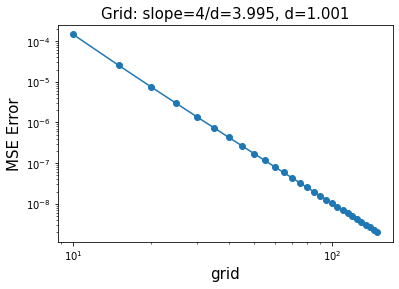

In [31]:
plt.plot(n_grids, errors, marker="o")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid',fontsize=15)
plt.ylabel('MSE Error',fontsize=15)
plt.title("Grid: slope=4/d=3.995, d=1.001",fontsize=15)

In [29]:
start_id = 10
end_id = -1
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-3.9953846455007733